# Sixth attempt at a world model
## Basic Process

In [14]:
# Settings and setup
import tensorflow as tf

# Set GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

tf.keras.utils.set_random_seed(42)

# Main Settings
ROLE = "TAGGER"
PRED_FRAMES_IN_ADVANCE = 5

# Encoder Settings
IMG_INPUT_SHAPE=(640, 640, 3)

NUM_DBS = 4
NUM_LAYERS_PER_DB = 1
NUM_FILTERS_PER_LAYER_OF_DB = 2

DOWNSCALING_LAYERS = 4
DOWNSCALING_FACTOR = 2
OUTPUT_SIZE = 64
ENC_DROPOUT = 0.25 # 0.5

# PREDICTOR
PRED_POSSIBLE_OUTCOMES = 8
PRED_ACTION_LAYERS = 2
PRED_ENCODED_LAYERS = 2
PRED_INTER_LAYERS = 5
PRED_INTER_LAYER_SIZE = 8 * PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE # This should scale to the number of predictions it makes and the size of each prediction
PRED_DROPOUT = 0.35

# Cost Calculator Settings
CC_INTER_LAYERS = 6
CC_INTER_LAYER_SIZE = 512
CC_DROPOUT = 0.25 # 0.5
CC_TOPLINE_DROPOUT = 0.5 # 0.75 # This dropout should address the difficulties and uncertenties of the predictors job by making this encoder provide somewhat generalizable encodings

# Action Generator Settings 
ACTIONS = 1
NUM_POSSIBLE_ACTIONS = 100
ACTION_SPACE_SMOOTHING = 5

# Training settings
BATCH_SIZE = 64

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Encoder

In [15]:
# Image segmenter base
from tensorflow.keras import layers, models

def create_dense_block(x, num_of_layers, num_filters, kernel_size=5):
    output_layers = [x]
    for l in range(num_of_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation="elu", padding="same")(x)
        output_layers.append(x)
        x = layers.Concatenate()(output_layers)
    return x

def create_transistion_down(x, layer_size_change, num_filters=None):
    if num_filters:
        x = layers.Conv2D(num_filters, 1, activation="elu", padding="same")(x)
    
    return layers.MaxPool2D(layer_size_change)(x)

# Keep track for skip connections and other things
skip_connections = []
previous_filters = [NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB]

# Num of filters: 4 (layers) * 32 (idk) + 64 (previous filters)
# Should prob figure out why this is

model_in = layers.Input(shape=IMG_INPUT_SHAPE)
x = layers.Conv2D(previous_filters[-1], 9, activation="elu", padding="same")(model_in)

for i in range(NUM_DBS):
    previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
    x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
    skip_connections.append(x)
    x = create_transistion_down(x, 2, num_filters=(previous_filters[-1]))


previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1]) 

dense_net = models.Model(model_in, x)

dense_net.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 640, 640, 2)          488       ['input_14[0][0]']            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 640, 640, 4)          204       ['conv2d_10[0][0]']           
                                                                                                  
 concatenate_5 (Concatenate  (None, 640, 640, 6)          0         ['conv2d_10[0][0]',           
 )                                                                   'conv2d_11[0][0]']     

In [16]:
# Encoder (Simple downscaler)

# Added encoder to flatten dense_net
# Sparse to dense conversion:
class SparseToDenseLayer(layers.Layer):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.inp_shape = input_shape
    
    def call(self, x):
        unsparse = lambda x: tf.reshape(tf.sparse.to_dense(x), self.inp_shape[1:])
        return tf.map_fn(unsparse, x, fn_output_signature=tf.TensorSpec(self.inp_shape[1:], dtype=float))
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_shape": self.inp_shape,
        })
        return config

encoder = models.Sequential()
inp = layers.Input(shape=IMG_INPUT_SHAPE, sparse=True)

encoder.add(inp)
encoder.add(SparseToDenseLayer(tuple(inp.type_spec.shape)))
encoder.add(layers.RandomFlip())
encoder.add(dense_net)
encoder.add(layers.Flatten())

for i in range(DOWNSCALING_LAYERS):
    encoder.add(layers.Dense(DOWNSCALING_FACTOR**(DOWNSCALING_LAYERS-i-1) * OUTPUT_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    encoder.add(layers.Dropout(ENC_DROPOUT))

# encoder.add(layers.BatchNormalization(axis=-1))
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sparse_to_dense_layer_1 (S  (None, 640, 640, 3)       0         
 parseToDenseLayer)                                              
                                                                 
 random_flip_1 (RandomFlip)  (None, 640, 640, 3)       0         
                                                                 
 model_6 (Functional)        (None, 40, 40, 22)        7932      
                                                                 
 flatten_1 (Flatten)         (None, 35200)             0         
                                                                 
 dense_23 (Dense)            (None, 512)               18022912  
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                      

# Predictor

In [17]:
# Build new predictor model

# Handle actionspace
keys = layers.Input(shape=ACTIONS)
pred_keys = keys

for _ in range(PRED_ACTION_LAYERS):
    pred_keys = layers.Dense(PRED_INTER_LAYER_SIZE//2, activation="elu",)(pred_keys)
    pred_keys = layers.Dropout(PRED_DROPOUT)(pred_keys)

# Handle encoded frame
encoded_frame = layers.Input(shape=OUTPUT_SIZE)
pred_frame = encoded_frame

for _ in range(PRED_ENCODED_LAYERS):
    pred_frame = layers.Dense(PRED_INTER_LAYER_SIZE//2, activation="elu",)(pred_frame)
    pred_frame = layers.Dropout(PRED_DROPOUT)(pred_frame)

# Combine them
predictor = tf.concat([pred_keys, pred_frame], axis=-1)
for _ in range(PRED_INTER_LAYERS):
    predictor = layers.Dense(PRED_INTER_LAYER_SIZE, activation="elu",)(predictor)
    predictor = layers.Dropout(PRED_DROPOUT)(predictor)

predictor = layers.Dense(PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE, activation="elu")(predictor)
predictor = tf.reshape(predictor, (tf.shape(keys)[0], PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
# predictor = layers.BatchNormalization(axis=-1)(predictor)

predictor = models.Model([keys, encoded_frame], predictor)
predictor.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_17 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 dense_27 (Dense)            (None, 2048)                 4096      ['input_16[0][0]']            
                                                                                                  
 dense_29 (Dense)            (None, 2048)                 133120    ['input_17[0][0]']            
                                                                                            

# Cost Calculator

In [18]:
cost_calculator = models.Sequential()
cost_calculator.add(layers.Input(shape=OUTPUT_SIZE))
cost_calculator.add(layers.Dropout(CC_TOPLINE_DROPOUT))

# Add internal layers
for _ in range(CC_INTER_LAYERS):
    cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    cost_calculator.add(layers.Dropout(CC_DROPOUT))

cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//2)) #, activation="elu"))
cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//4)) #, activation="elu"))
cost_calculator.add(layers.Dense(1, activation="sigmoid")) #, activation="elu"))

cost_calculator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 512)               33280     
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dropout_35 (Dropout)        (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dropout_36 (Dropout)        (None, 512)              

# Training

In [19]:
# Settings
ENCODER_AND_COST_AND_PRED_LR = 1 * 10**-4
COST_LR = 5 * 10**-5
PRED_LR = 5 * 10**-6

MAX_EPOCHS = 200

In [20]:
# MPL settings
from matplotlib import pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

(24389, 2) (1, 2)
tf.Tensor([24389   640   640     3], shape=(4,), dtype=int32) tf.Tensor([24389     1], shape=(2,), dtype=int32) tf.Tensor([24389     1], shape=(2,), dtype=int32) tf.Tensor([24389     1], shape=(2,), dtype=int32)
tf.Tensor(1.0, shape=(), dtype=float16) tf.Tensor(0.0, shape=(), dtype=float16)


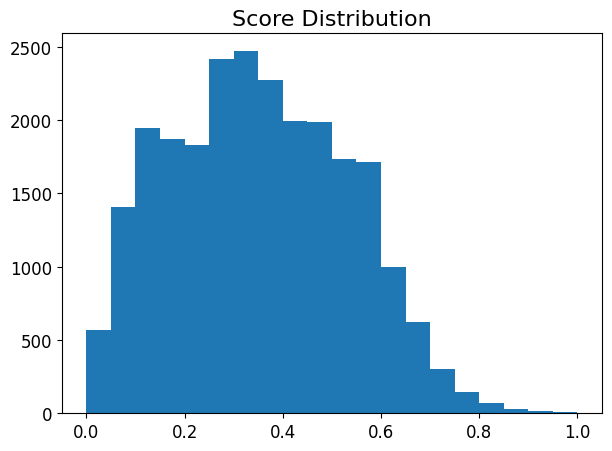

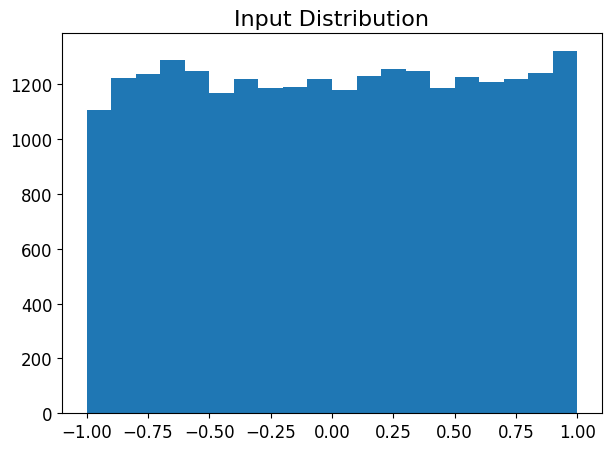

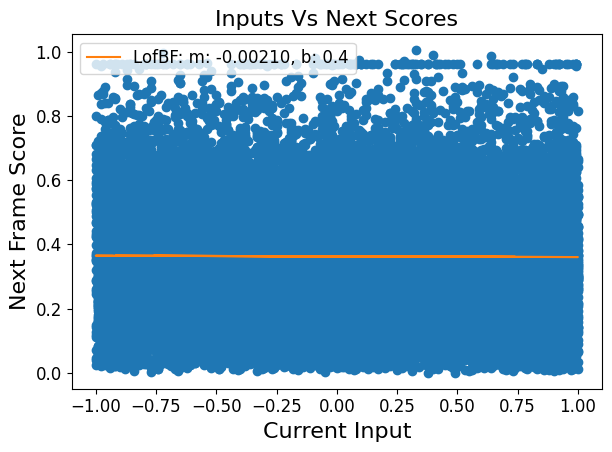

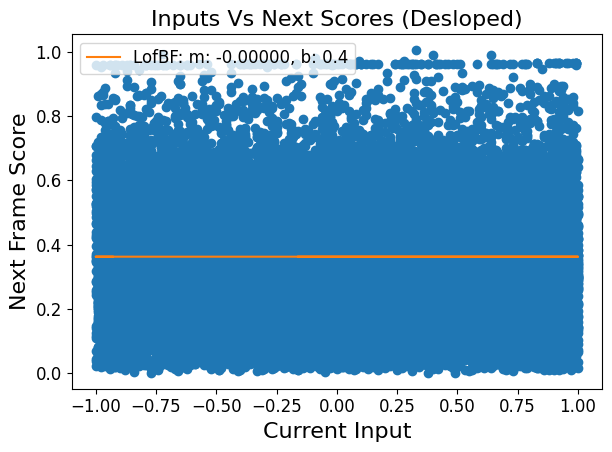

In [21]:
# Create dataset
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import RobustScaler
import numpy as np

with tf.device("cpu:0"):
    runs = pd.read_csv("game_runs.csv")[["Run", "Winner"]].sample(frac=1).values.tolist()
    all_frames = []
    all_next_frames = []
    all_input = []
    all_scores = []
    all_tagger_poses = []
    all_taggee_poses = []
    for run, winner in runs[:500]:
        frames = tf.cast(tf.io.deserialize_many_sparse(tf.io.parse_tensor(tf.io.read_file("runs/%d/frames.proto_tensor" % run), tf.dtypes.string), float), tf.float16)
        all_frames.append(frames)
    
        if ROLE == "TAGGER":
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_inputs.proto_tensor" % run), float))
        else:
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/tagee_inputs.proto_tensor" % run), float))
    
        tagger_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_poses.proto_tensor" % run), float)
        taggee_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/taggee_poses.proto_tensor" % run), float)

        all_tagger_poses.append(tagger_poses)
        all_taggee_poses.append(taggee_poses)
        
        scores_normalizer = tf.math.sqrt(tf.cast(tf.math.square(IMG_INPUT_SHAPE[0]) + tf.math.square(IMG_INPUT_SHAPE[1]), float))
        
        if ROLE == "TAGGER":
            scores = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1))/scores_normalizer
        else:
            scores = (scores_normalizer - tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1)))/scores_normalizer
        
        if winner != ROLE:
            # Set all last scores to be 1
            # scores = tf.concat([scores[:-5:], tf.repeat(tf.constant([1.0]), repeats=5)], axis=0)
            
            # Make scores at the end more linear
            dist = 0.9 - scores[-5].numpy() # The constant number here can be editted to make the distributions plotted below have fewer outliers
            # It should be varied to create datasets that are complex without too many outliers
            # My new hypothesis is that smaller is better because it will emphasize the distance rewards more.  There should be no visible outliers in the final data
            # Thinking about this, it def shouldn't be set by hand.  I should really come up with a formula, but I don't know how without knowing the values of the entire dataset
            smoothed_end = [scores[-5].numpy() + (dist / 5 * (i + 1)) for i in range(5)]
            scores = tf.concat([scores[:-5:], tf.constant(smoothed_end, float)], axis=0)

        all_scores.append(scores)
        # print(run)

    # all_next_frames = tf.concat([frame[PRED_FRAMES_IN_ADVANCE:] for frame in all_frames], axis=0)
    # Sampling every other frame
    dense_to_sparse = lambda x: tf.SparseTensor(
        tf.where(tf.not_equal(x, tf.constant(0.0, tf.float16))),
        tf.gather_nd(x, tf.where(tf.not_equal(x, tf.constant(0.0, tf.float16)))),
        x.shape
    )
    
    all_frames = tf.sparse.concat(0, [dense_to_sparse(tf.sparse.to_dense(frame)[:-PRED_FRAMES_IN_ADVANCE:2]) for frame in all_frames])
    all_input = tf.cast(tf.concat([input[:-PRED_FRAMES_IN_ADVANCE:2] for input in all_input], axis=0), tf.float16)
    all_future_scores = tf.cast(tf.concat([score[PRED_FRAMES_IN_ADVANCE::2] for score in all_scores], axis=0), tf.float16)
    all_scores = tf.cast(tf.concat([score[:-PRED_FRAMES_IN_ADVANCE:2] for score in all_scores], axis=0), tf.float16)

    all_tagger_poses = tf.cast(tf.concat([pos[:-PRED_FRAMES_IN_ADVANCE:2] for pos in all_tagger_poses], axis=0), tf.float16)
    all_taggee_poses = tf.cast(tf.concat([pos[:-PRED_FRAMES_IN_ADVANCE:2] for pos in all_taggee_poses], axis=0), tf.float16)

    # Normalize scores
    scaler = RobustScaler()
    all_scores = tf.expand_dims(all_scores, axis=-1)
    all_scores = tf.numpy_function(lambda x: scaler.fit_transform(x), [all_scores], float)
    all_scores_min, all_scores_max = tf.math.reduce_min(all_scores, keepdims=True), tf.math.reduce_max(all_scores, keepdims=True)
    all_scores = (all_scores - all_scores_min) / (all_scores_max - all_scores_min)
    all_scores = tf.cast(all_scores, tf.float16)

    # Normalize future scores
    all_future_scores = tf.expand_dims(all_future_scores, axis=-1)
    all_future_scores = tf.numpy_function(lambda x: scaler.transform(x), [all_future_scores], float)
    all_future_scores = (all_future_scores - all_scores_min) / (all_scores_max - all_scores_min)
    all_future_scores = tf.cast(all_future_scores, tf.float16)
    
    # Sum the inputs
    mult_inputs = tf.constant([[1, -1]], tf.float16)
    print(all_input.shape, mult_inputs.shape)
    all_input *= mult_inputs
    all_input = tf.math.reduce_sum(all_input, axis=-1, keepdims=True)

    # Round the inputs
    all_input *= 100
    all_input = tf.math.round(all_input)/100
    
    print(tf.shape(all_frames), tf.shape(all_input), tf.shape(all_scores), tf.shape(all_future_scores)) #, tf.shape(all_delta_scores))
    print(tf.math.reduce_max(all_scores), tf.math.reduce_min(all_scores)) # , tf.math.reduce_max(all_delta_scores), tf.math.reduce_min(all_delta_scores))

    # Plot histogram of scores
    plt.hist(all_scores[:, 0].numpy(), bins=20)
    plt.title("Score Distribution")
    plt.tight_layout()
    plt.show()

    # Plot histogram of input
    plt.hist(all_input[:, 0].numpy(), bins=20)
    plt.title("Input Distribution")
    plt.tight_layout()
    plt.show()

    # Plot how inputs relate to scores
    plt.scatter(all_input[:, 0].numpy(), all_future_scores[:, 0].numpy())
    a, b = np.polyfit(all_input[:, 0].numpy().astype(float), all_future_scores[:, 0].numpy().astype(float), 1)
    plt.plot(all_input[:, 0].numpy(), a*all_input[:, 0].numpy()+b, label="LofBF: m: %.5f, b: %.1f" % (a, b), c="tab:orange")
    plt.xlabel("Current Input")
    plt.ylabel("Next Frame Score")
    plt.title("Inputs Vs Next Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Experimental desloping
    all_future_scores = all_future_scores - (a * all_input)
    
    # Plot how inputs relate to scores (desloped)
    plt.scatter(all_input[:, 0].numpy(), all_future_scores[:, 0].numpy())
    a, b = np.polyfit(all_input[:, 0].numpy().astype(float), all_future_scores[:, 0].numpy().astype(float), 1)
    plt.plot(all_input[:, 0].numpy(), a*all_input[:, 0].numpy()+b, label="LofBF: m: %.5f, b: %.1f" % (a, b), c="tab:orange")
    plt.xlabel("Current Input")
    plt.ylabel("Next Frame Score")
    plt.title("Inputs Vs Next Scores (Desloped)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.hist(all_delta_scores[:, 0].numpy(), bins=100)
    # plt.title("Delta Score Distribution")
    # plt.show()

    # Make DS
    big_train_ds = tf.data.Dataset.from_tensor_slices((all_frames, all_input, all_scores, all_future_scores)) # , all_delta_scores))
    big_train_ds = big_train_ds.shuffle(big_train_ds.cardinality())
    big_valid_ds = big_train_ds.shard(10, 8)
    big_test_ds = big_train_ds.shard(10, 9)
    big_train_ds = big_train_ds.take((8 * big_train_ds.cardinality())//10)

    # Make debug DS
    big_debug_train_ds = tf.data.Dataset.from_tensor_slices((all_frames, all_scores, all_tagger_poses, all_taggee_poses))
    big_debug_train_ds = big_debug_train_ds.shuffle(big_debug_train_ds.cardinality())
    big_debug_valid_ds = big_debug_train_ds.shard(10, 8)
    big_debug_test_ds = big_debug_train_ds.shard(10, 9)
    big_debug_train_ds = big_debug_train_ds.take((8 * big_debug_train_ds.cardinality())//10)

In [22]:
# Train encoder, predictor, and cost calculaor together
from tensorflow.keras import optimizers

def minimum_mse(y_true, y_pred):
    se = tf.math.square(tf.expand_dims(y_true, axis=1) - y_pred)
    mse = tf.math.reduce_mean(se, axis=2) # because axis 0 is batch and 1 is the 4 predictions
    return tf.math.reduce_min(mse, axis=1) # because axis 0 is batch

def mse(y_true, y_pred):
    se = tf.math.square(tf.expand_dims(y_true, axis=1) - y_pred)
    return tf.math.reduce_mean(se, axis=[1, 2]) # Because axis 0 is batch axis

def combined_loss(y_true, y_pred, mse_weight=0.1):
    return minimum_mse(y_true, y_pred) + mse_weight * mse(y_true, y_pred)

# Comment out these two lines to train the encoder from scratch
# encoder = tf.keras.models.load_model("encoder_%s.keras" % ROLE)
# cost_calculator = tf.keras.models.load_model("cost_calculator_%s.keras" % ROLE)
# predictor = tf.keras.models.load_model("predictor_%s.keras" % ROLE)

frame_and_score = lambda w, x, y, z: (w, y)
enc_cost_calc = models.Sequential([layers.Input(shape=IMG_INPUT_SHAPE, sparse=True), encoder, cost_calculator])
enc_cost_calc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_AND_PRED_LR), loss="mse", metrics=["mse"])
enc_cost_calc.summary()

train_ds_frame_and_score = big_train_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE, drop_remainder=True).cache()
valid_ds_frame_and_score = big_valid_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE, drop_remainder=True).cache()

frame_key_next_cost = lambda w, x, y, z: ((w, x), z)
cur_frame_in = layers.Input(shape=IMG_INPUT_SHAPE, sparse=True)
cur_key_in = layers.Input(shape=ACTIONS)
enc_pred_enc = encoder(cur_frame_in)
enc_pred_enc = predictor((cur_key_in, enc_pred_enc))
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
enc_pred_enc = cost_calculator(enc_pred_enc)
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0], PRED_POSSIBLE_OUTCOMES, 1))
enc_pred_enc = models.Model([cur_frame_in, cur_key_in], enc_pred_enc)
enc_pred_enc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_AND_PRED_LR), loss=combined_loss, metrics=[minimum_mse, mse])
enc_pred_enc.summary()

train_ds_frame_key_next_frame = big_train_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE, drop_remainder=True).cache()
valid_ds_frame_key_next_frame = big_valid_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE, drop_remainder=True).cache()

best_encoder, best_cost_calculator, best_pred = None, None, None
min_cc_losses, min_pred_losses = 10**10, 10**10

time_without_save = 0

for i in range(MAX_EPOCHS):
    train_iter_frame_and_score = iter(train_ds_frame_and_score)
    train_iter_frame_key_next_frame = iter(train_ds_frame_key_next_frame)
    
    while True:
        try:
            # Fit cost calculator and encoder to one batch
            cost_calculator.trainable = True
            data = train_iter_frame_and_score.next()
            enc_cc_loss = enc_cost_calc.train_on_batch(
                data[0], data[1]
            )

            # Fit predictor and encoder to one batch
            cost_calculator.trainable = False
            data = train_iter_frame_key_next_frame.next()
            enc_pred_enc.train_on_batch(
                data[0], data[1]
            )
        except StopIteration:
            break

    enc_cc_loss = enc_cost_calc.evaluate(valid_ds_frame_and_score, return_dict=True)["loss"]
    enc_pred_loss = enc_pred_enc.evaluate(valid_ds_frame_key_next_frame, return_dict=True)["loss"]
            
    if enc_cc_loss <= min_cc_losses and enc_pred_loss <= min_pred_losses:
        print(i, "Saving")

        min_cc_losses = enc_cc_loss
        min_pred_losses = enc_pred_loss
        
        min_cc_losses
        encoder.save("encoder_%s.keras" % ROLE)
        cost_calculator.save("cost_calculator_%s.keras" % ROLE)
        predictor.save("predictor_%s.keras" % ROLE)
        time_without_save = 0
    else:
        print(i)
        time_without_save += 1

    if time_without_save > MAX_EPOCHS//10:
        break

encoder = tf.keras.models.load_model("encoder_%s.keras" % ROLE, custom_objects={"SparseToDenseLayer": SparseToDenseLayer})
cost_calculator = tf.keras.models.load_model("cost_calculator_%s.keras" % ROLE)
predictor = tf.keras.models.load_model("predictor_%s.keras" % ROLE, custom_objects={"combined_loss": combined_loss, "minimum_mse": minimum_mse, "mse": mse})

cost_calculator.trainable = True
encoder.trainable = False

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64)                18203324  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 1510913   
                                                                 
Total params: 19714237 (75.20 MB)
Trainable params: 19714237 (75.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 640, 640, 3)]        0         []                            
                                                                                              

In [23]:
# Train cost calculator without encoder and lower lr

cost_calculator.compile(optimizers.Adam(learning_rate=COST_LR), loss="mse", metrics=["mse"])
cost_calculator.summary()

encodings_and_score = lambda w, x, y, z: (encoder(w), y)

encoding_cost_train_ds = big_train_ds.batch(BATCH_SIZE, drop_remainder=True).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
encoding_cost_valid_ds = big_valid_ds.batch(BATCH_SIZE, drop_remainder=True).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

cost_calculator.fit(
    encoding_cost_train_ds,
    validation_data=encoding_cost_valid_ds,
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

cost_calculator.save("cost_calculator_%s.keras" % ROLE)
cost_calculator.trainable = False

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 512)               33280     
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dropout_35 (Dropout)        (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dropout_36 (Dropout)        (None, 512)              

In [24]:
# Train prediction
frame_key_next_cost = lambda w, x, y, z: ((w, x), z)
cur_frame_in = layers.Input(shape=IMG_INPUT_SHAPE, sparse=True)
cur_key_in = layers.Input(shape=ACTIONS)
enc_pred_enc = encoder(cur_frame_in)
enc_pred_enc = predictor((cur_key_in, enc_pred_enc))
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
enc_pred_enc = cost_calculator(enc_pred_enc)
enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0], PRED_POSSIBLE_OUTCOMES, 1))
enc_pred_enc = models.Model([cur_frame_in, cur_key_in], enc_pred_enc)
enc_pred_enc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_AND_PRED_LR), loss=combined_loss, metrics=[minimum_mse, mse])
enc_pred_enc.summary()

train_ds_frame_key_next_frame = big_train_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE, drop_remainder=True).cache()
valid_ds_frame_key_next_frame = big_valid_ds.map(frame_key_next_cost, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE, drop_remainder=True).cache()

with tf.device("cpu:0"):
    apply_encoder = lambda w, x, y, z: ((x, tf.cast(encoder(w), tf.float16)), z)
    pred_train_ds = big_train_ds.batch(BATCH_SIZE, drop_remainder=True).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
    pred_valid_ds = big_valid_ds.batch(BATCH_SIZE, drop_remainder=True).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

with tf.device("gpu:0"):
    cur_frame_in = layers.Input(shape=OUTPUT_SIZE)
    cur_key_in = layers.Input(shape=ACTIONS)
    enc_pred_enc = predictor((cur_key_in, cur_frame_in))
    enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
    enc_pred_enc = cost_calculator(enc_pred_enc)
    enc_pred_enc = tf.reshape(enc_pred_enc, (tf.shape(cur_frame_in)[0], PRED_POSSIBLE_OUTCOMES, 1))
    enc_pred_enc = models.Model([cur_key_in, cur_frame_in], enc_pred_enc)
    enc_pred_enc.compile(optimizers.Adam(learning_rate=PRED_LR), loss=combined_loss, metrics=[minimum_mse, mse])
    enc_pred_enc.summary()
    
    enc_pred_enc.fit(
        pred_train_ds,
        validation_data=pred_valid_ds,
        epochs=MAX_EPOCHS,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
    )

predictor.save("predictor_%s.keras" % ROLE)
predictor.trainable=False

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.shape_10 (TFO  (4,)                         0         ['input_22[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 input_23 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 64)                   1820332   ['input_22[0][0]']      

In [25]:
# Train action generator

@tf.function
def define_action(encoded_frames, smoothing=ACTION_SPACE_SMOOTHING, num_actions=NUM_POSSIBLE_ACTIONS, ret_predictions=False):
    actions = tf.cast(tf.expand_dims(tf.linspace(-1, 1, num_actions), axis=-1), float)
    print(tf.shape(actions))
    actions = tf.repeat(tf.expand_dims(actions, axis=0), repeats=tf.shape(encoded_frames)[0], axis=0)
    print(tf.shape(actions))

    # Now actions has shape (batch_size, num_actions, 1)
    # Make it have shape (num_actions, batch_size, 1)
    actions = tf.transpose(actions, perm=[1, 0, 2])

    predictions = tf.map_fn(
        lambda x: predictor((x, encoded_frames)),
        actions,
        fn_output_signature=tf.TensorSpec((None, PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE), float)
    )
    if ret_predictions:
        return predictions, actions

    # Above returns the predicted scores in shape (num_actions, batch_size, num_predictons, encoded_layer_size)
    # Reshape to (num_actions * batch_size * num_predictons, encoded_layer_size)
    pred_shape = tf.shape(predictions)
    predictions = tf.reshape(predictions, (pred_shape[0] * pred_shape[1] * pred_shape[2], pred_shape[3]))

    costs = cost_calculator(predictions)
    
    # Costs returned as (num_actions * batch_size * num_predictons, 1)
    # Reshape to (num_actions, batch_size, num_predictons) then (batch_size, num_actions, num_predictons) then avg to (batch_size, num_actions)
    costs = tf.reshape(costs, (pred_shape[0], pred_shape[1], pred_shape[2]))
    costs = tf.transpose(costs, perm=[1, 0, 2])
    avg_costs = tf.math.reduce_mean(costs, axis=-1)

    # Use numpy to smooth each set of actions
    actual_num_actions = num_actions - 2 * smoothing
    smoothing_func = lambda y: tf.nn.convolution(
        tf.expand_dims(tf.expand_dims(y, axis=-1), axis=0), filters=tf.ones((smoothing, 1, 1)),
        padding="SAME"
    )[0, smoothing:-smoothing, 0]/smoothing
    # smoothing_func = lambda y: tf.numpy_function(lambda x: (np.convolve(x, np.ones(smoothing), 'same')[smoothing:-smoothing]/smoothing).astype(np.single), [y], float)
    smoothed_costs = tf.map_fn(smoothing_func, avg_costs, fn_output_signature=tf.TensorSpec((actual_num_actions,), float))
    smoothed_actions = smoothing_func(actions[:, 0, 0])
    
    # return the argmin (normalized to actual input) of the smoothed function.  In addition, return the cost tensors
    moves = tf.math.argmin(smoothed_costs, axis=-1)
    moves = tf.gather(smoothed_actions, moves)
    moves = tf.expand_dims(moves, axis=-1)
    return moves, costs, smoothed_costs


class KerasGenActionLayer(layers.Layer):
    def call(self, x, training=None):
        print(tf.shape(x))
        return define_action(x, smoothing=ACTION_SPACE_SMOOTHING, num_actions=NUM_POSSIBLE_ACTIONS)[0]


inp = layers.Input(shape=IMG_INPUT_SHAPE, sparse=True)
action_gen = encoder(inp)
action_gen = KerasGenActionLayer()(action_gen)

action_gen = models.Model(inp, action_gen)
action_gen.track_pred_model = predictor
action_gen.track_cost_calculator = cost_calculator

action_gen.summary()
action_gen.save("action_gen_%s.tf" % ROLE, save_format="tf")

Tensor("keras_gen_action_layer_1/Shape:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(3,), dtype=int32)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 640, 640, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 64)                18203324  
                                                                 
 keras_gen_action_layer_1 (  (None, 1)                 0         
 KerasGenActionLayer)                                            
                                                                 
 model_7 (Functional)        (None, 8, 64)             94534144  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 1510913   
                                  

Tensor("model_11/keras_gen_action_layer_1/Shape:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(3,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
INFO:tensorflow:Assets written to: action_gen_TAGGER.tf/assets


INFO:tensorflow:Assets written to: action_gen_TAGGER.tf/assets


## Debugging

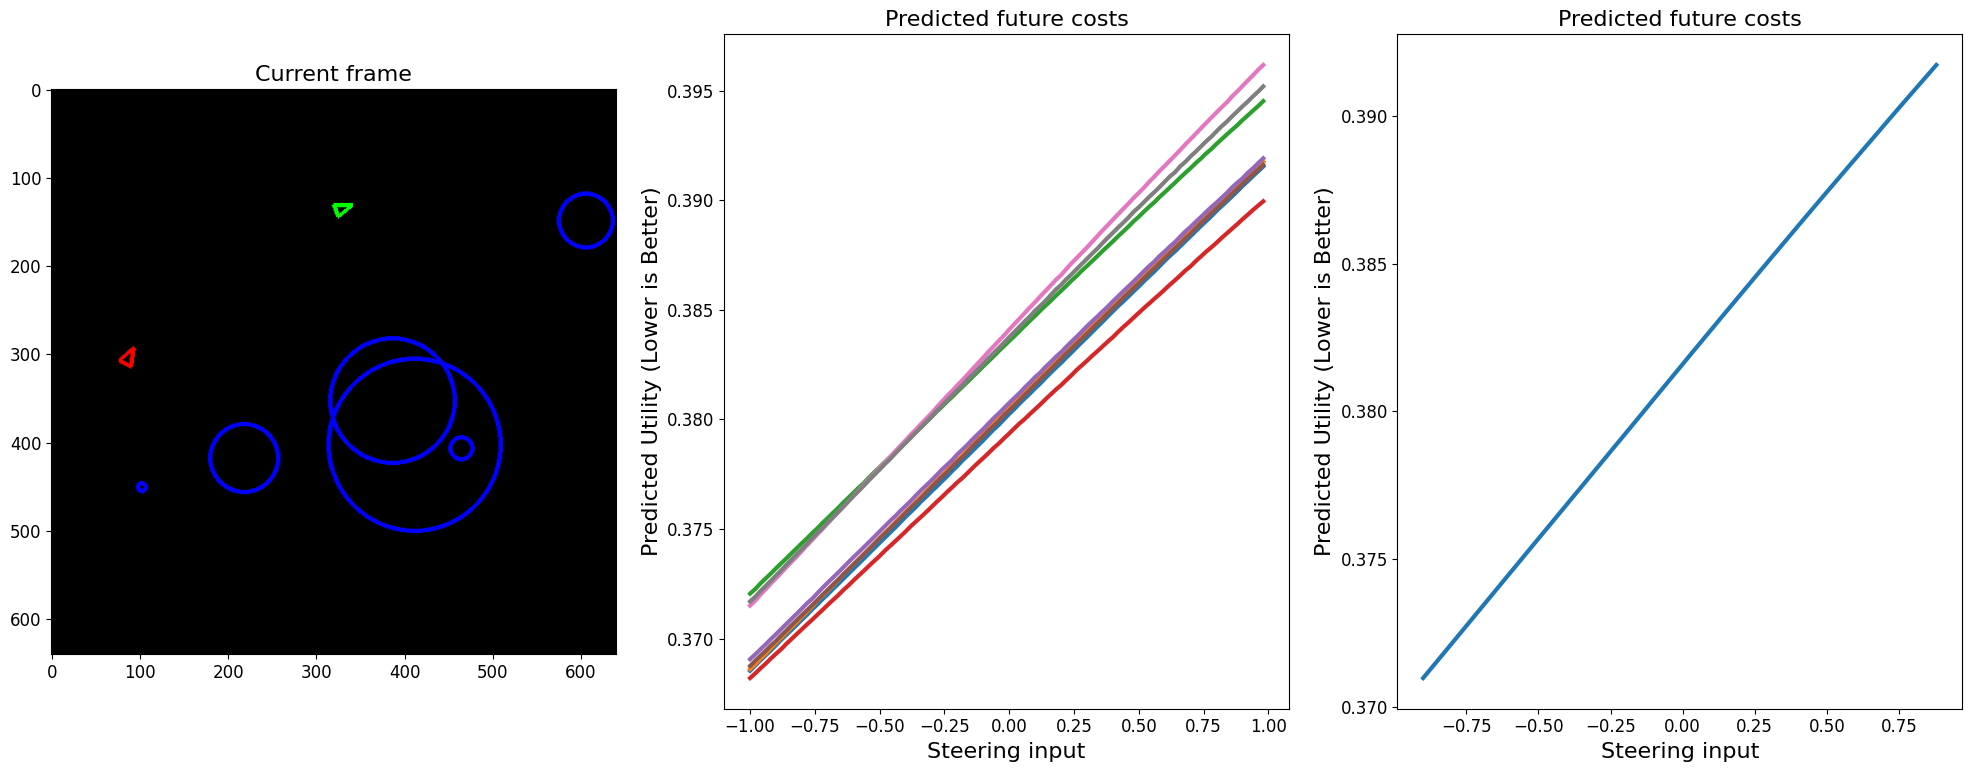

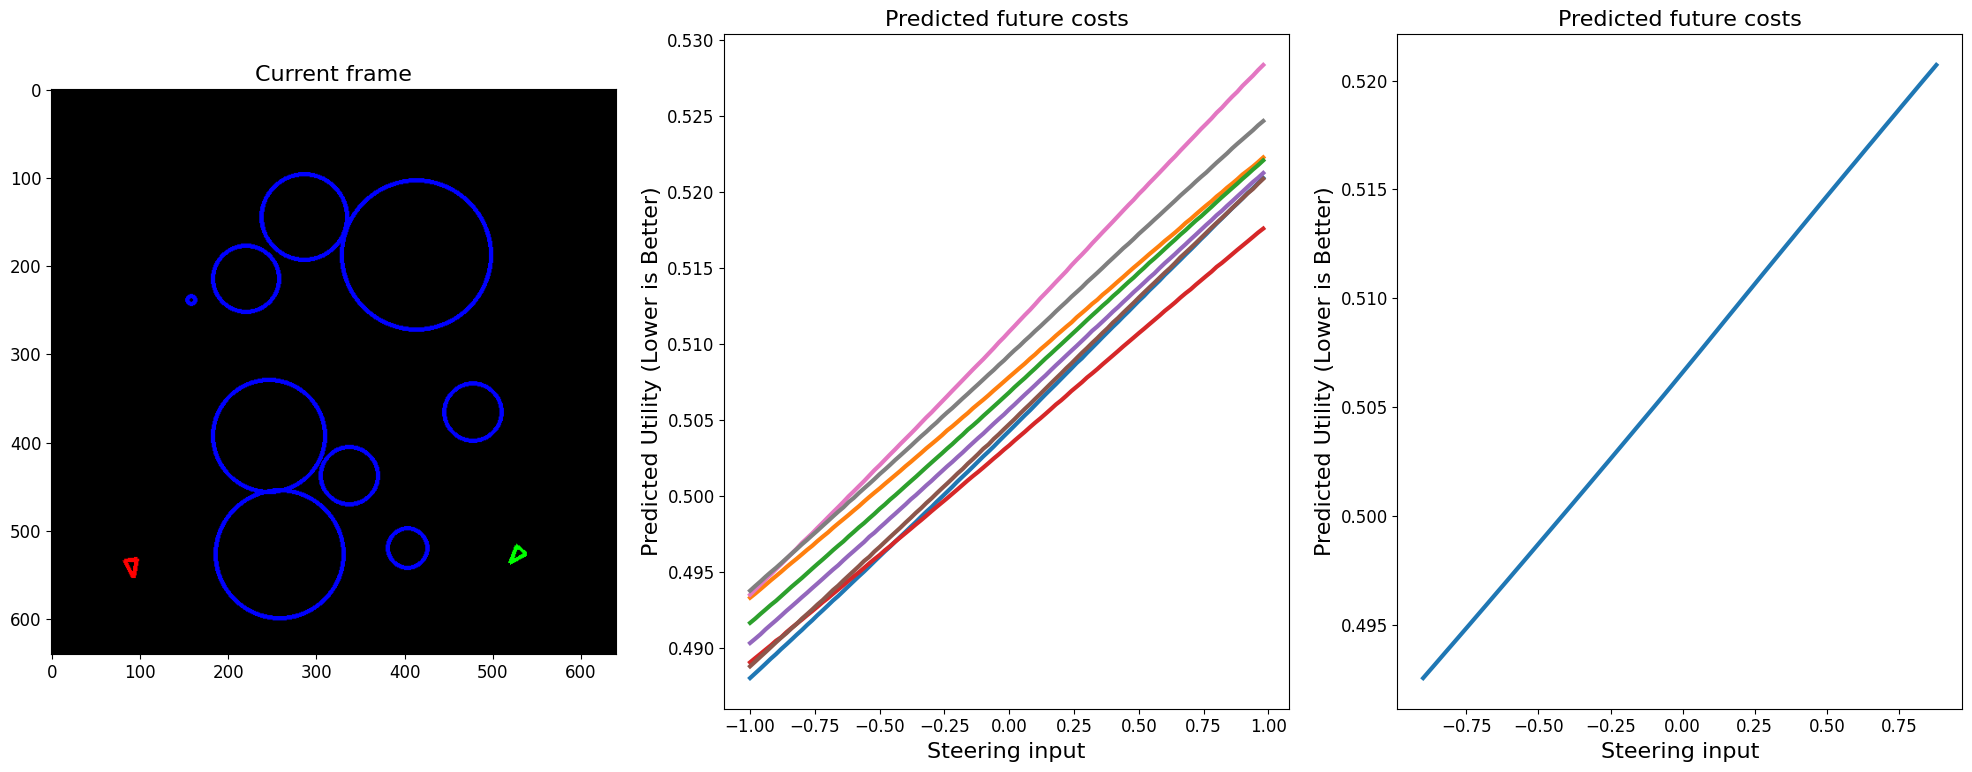

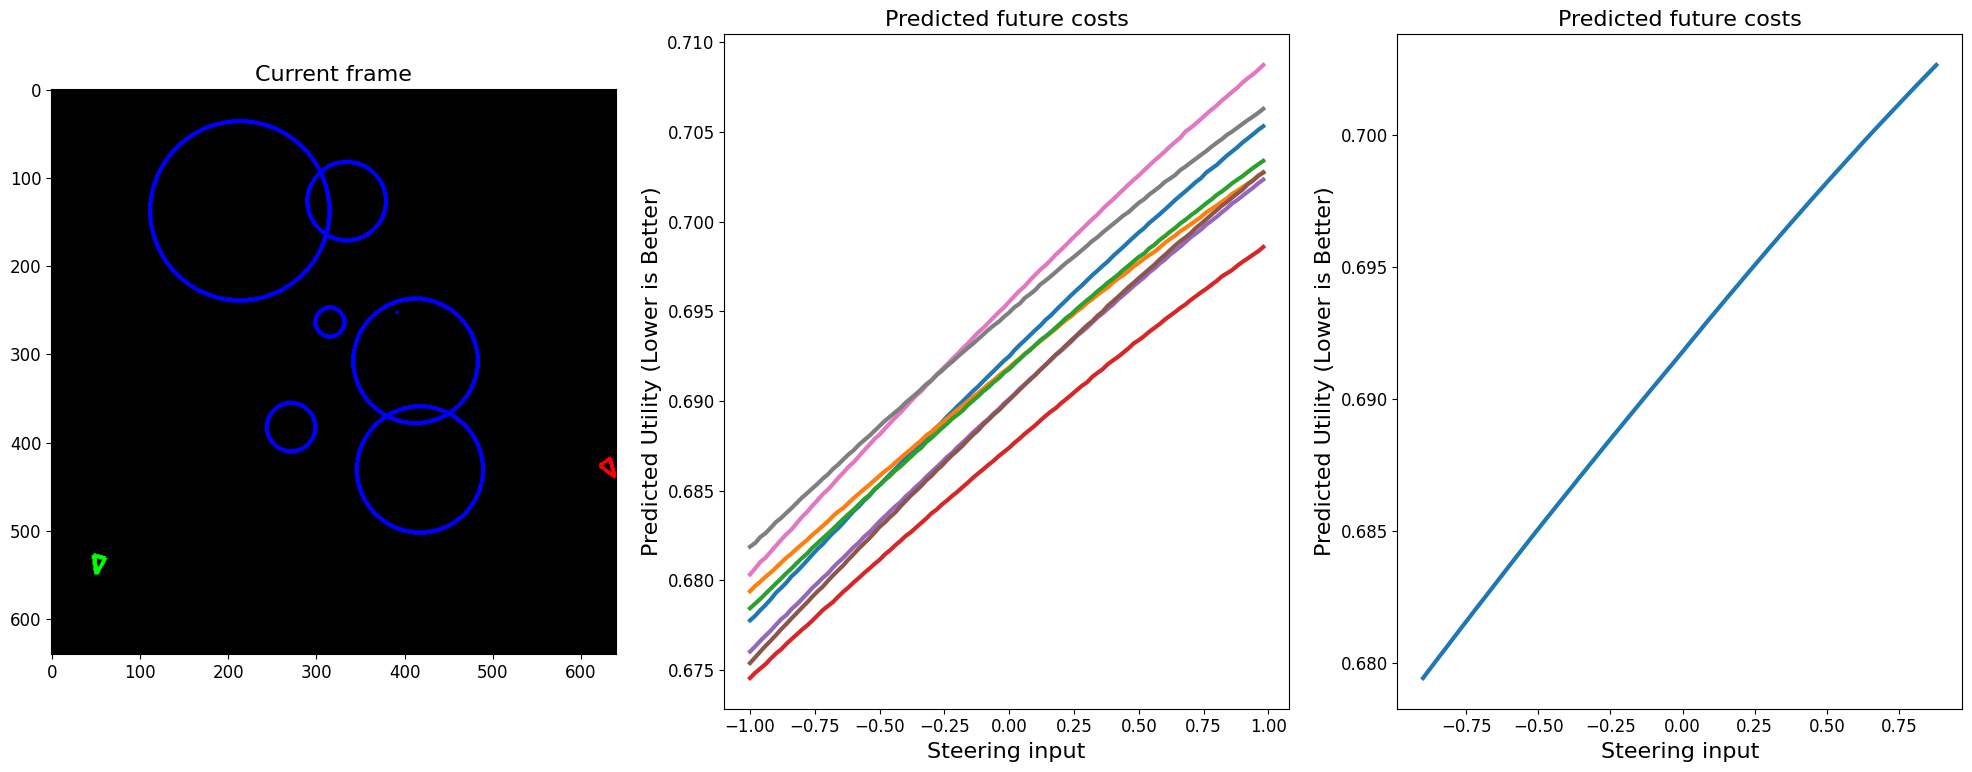

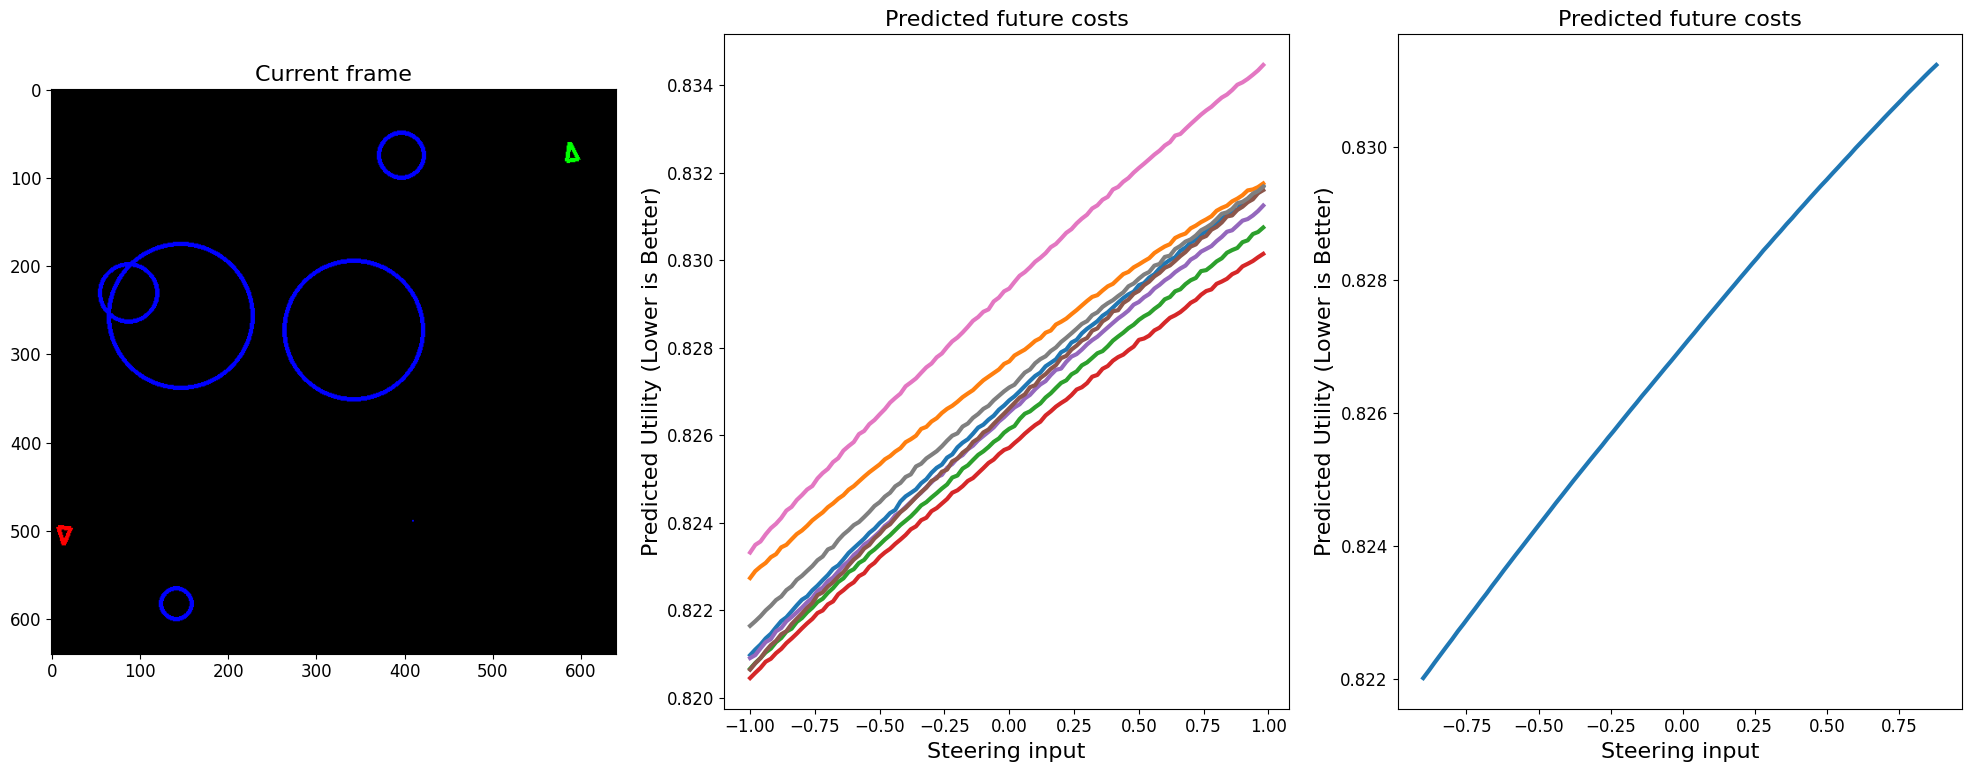

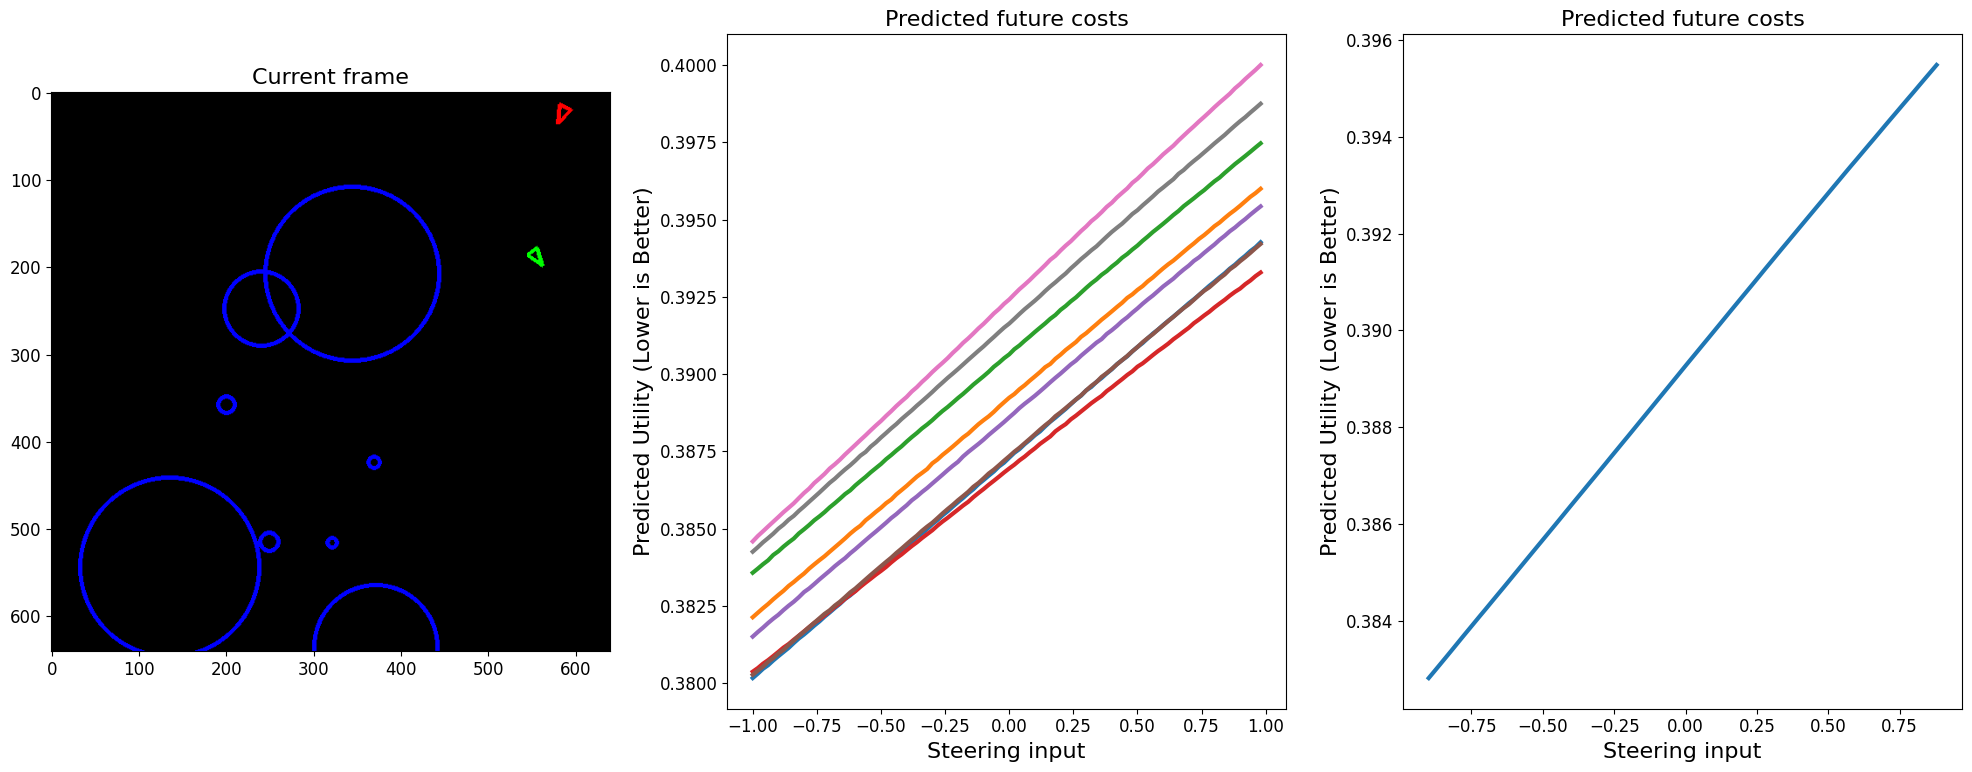

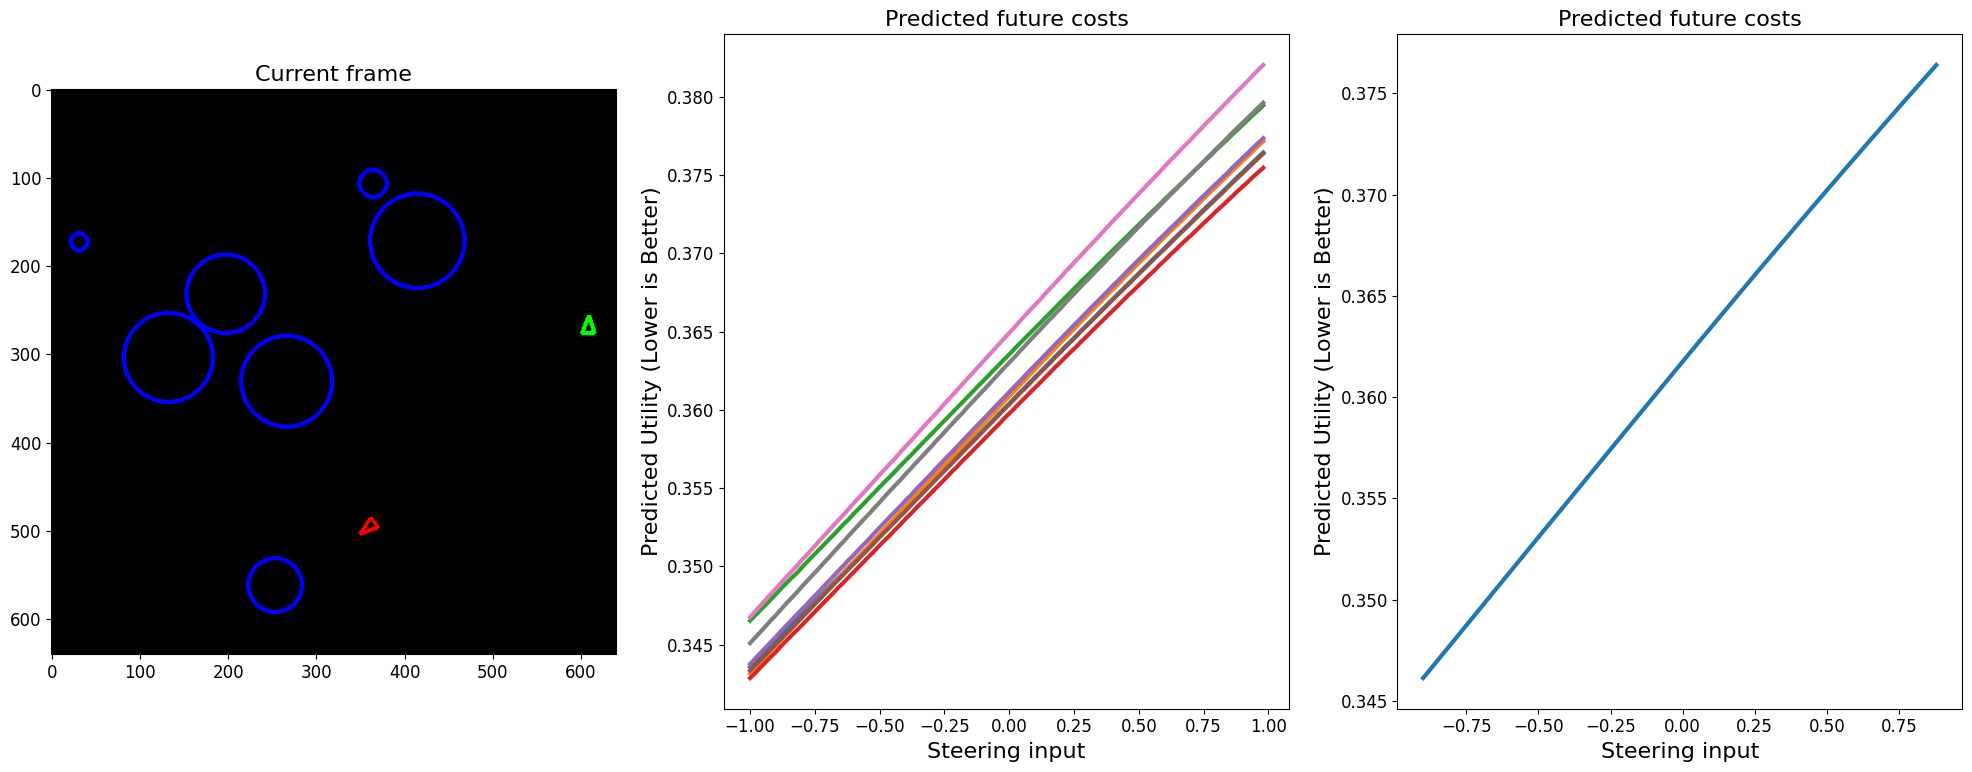

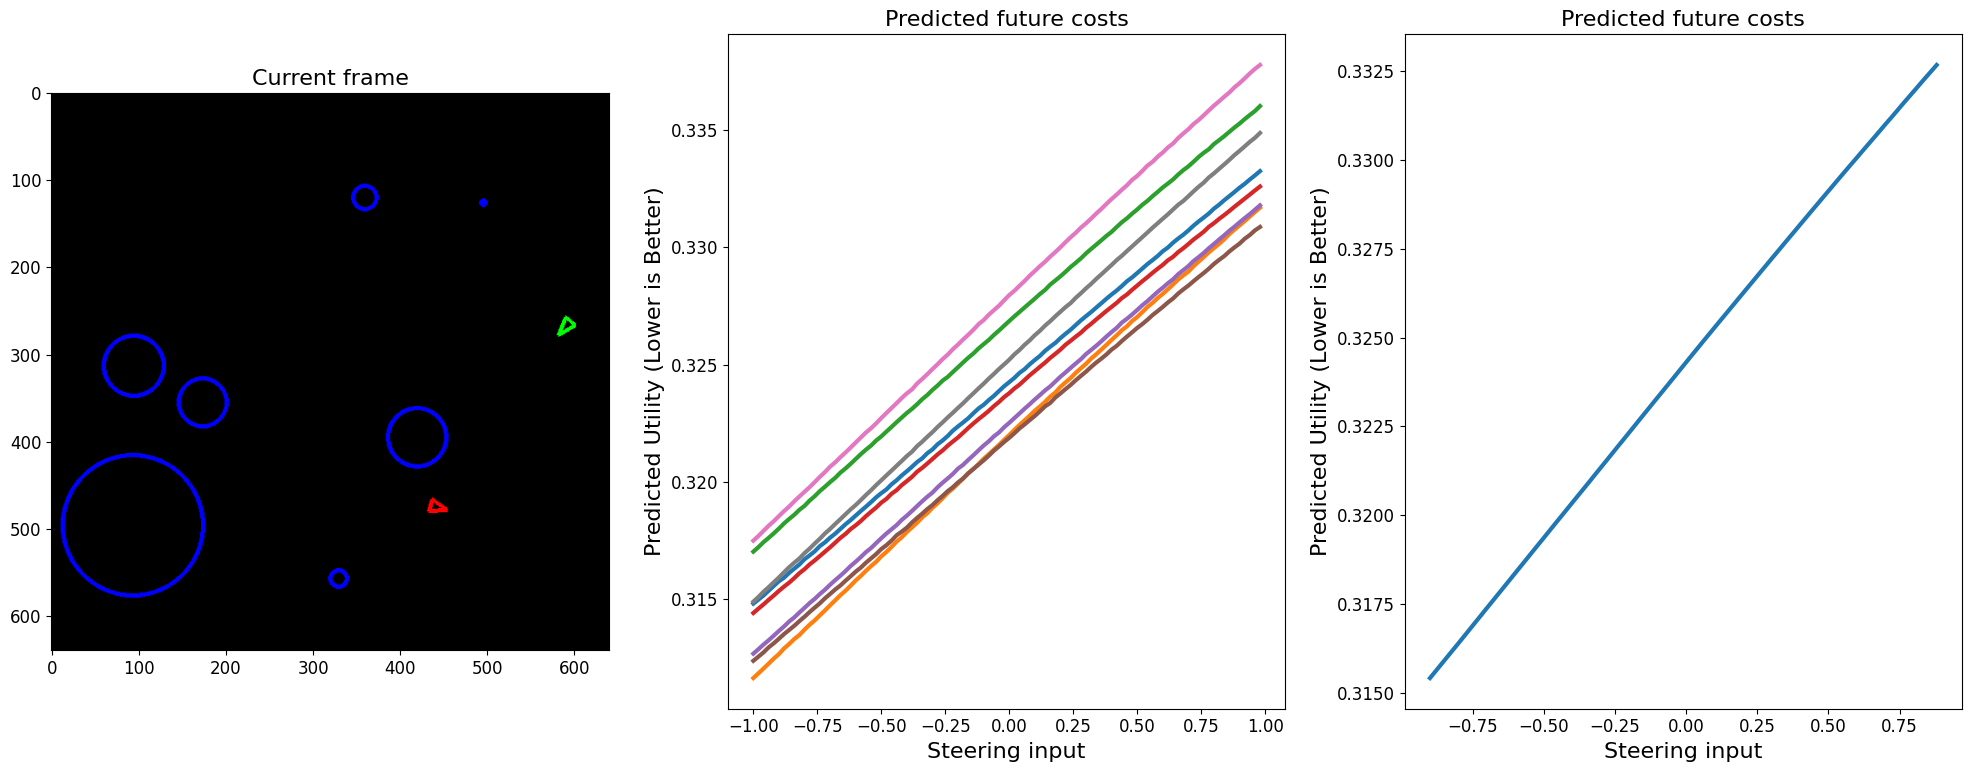

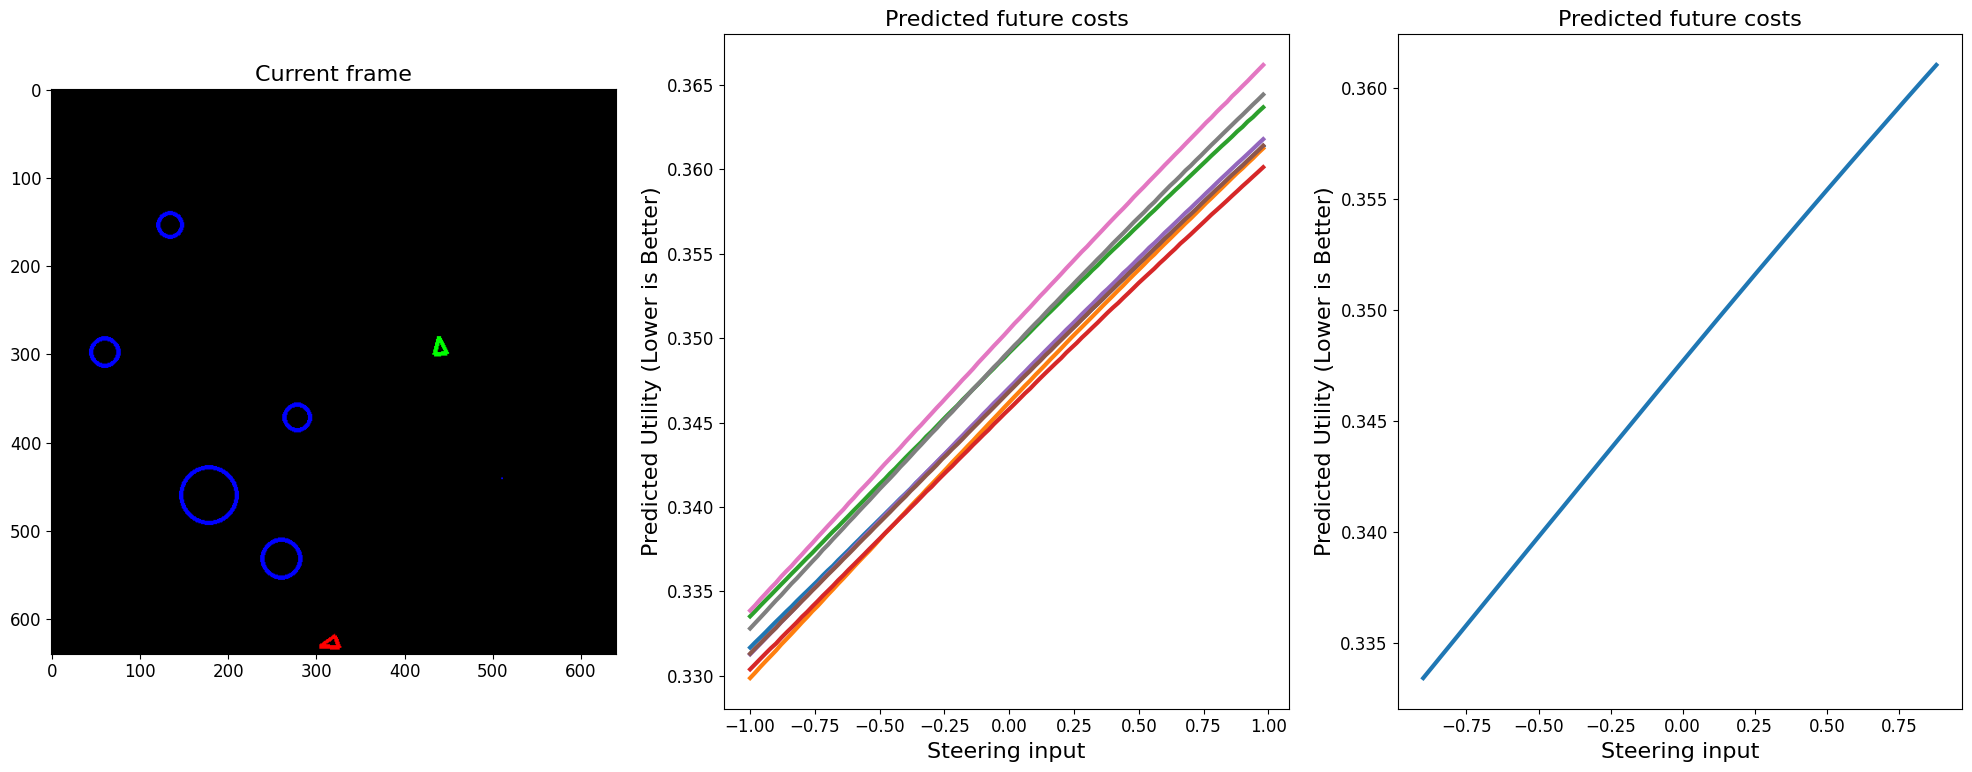

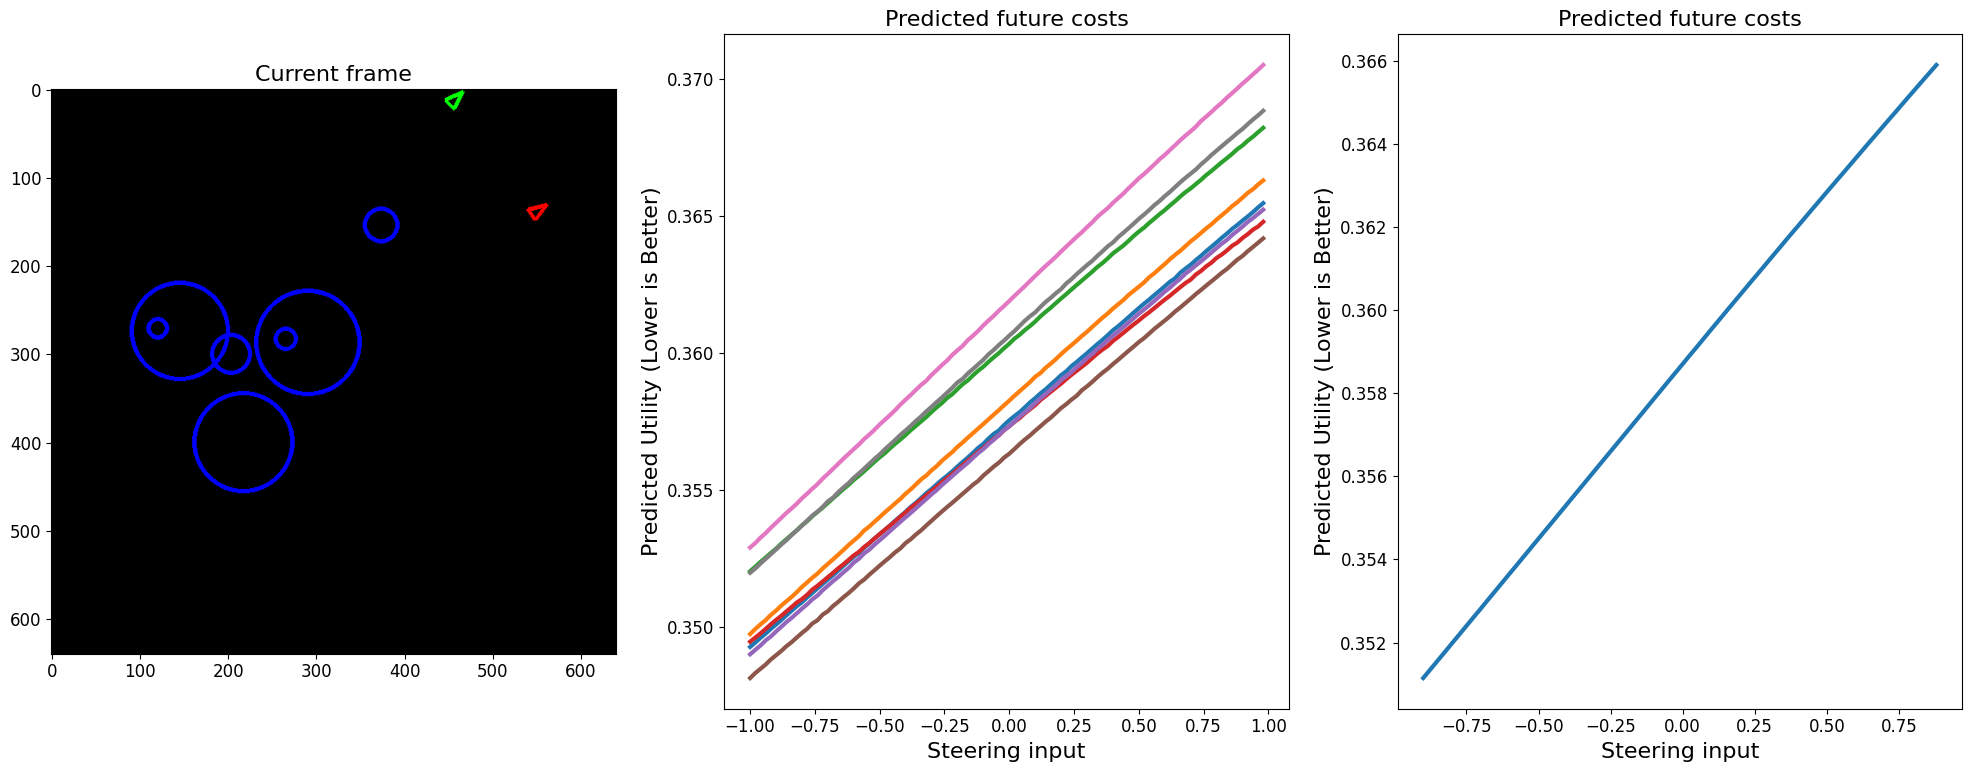

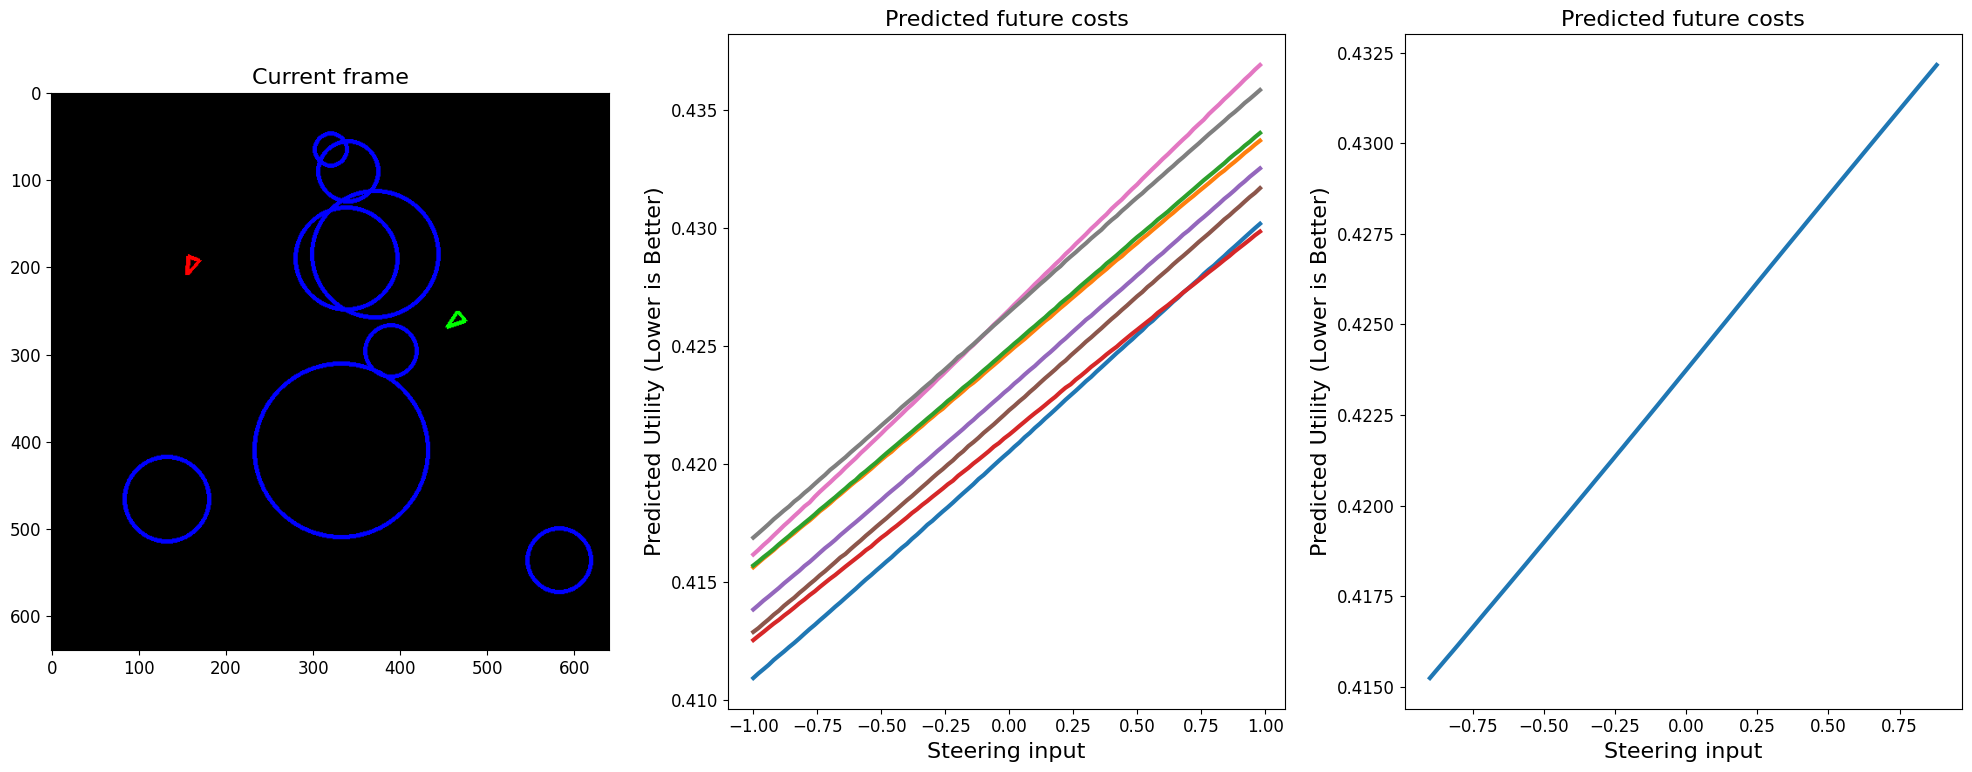

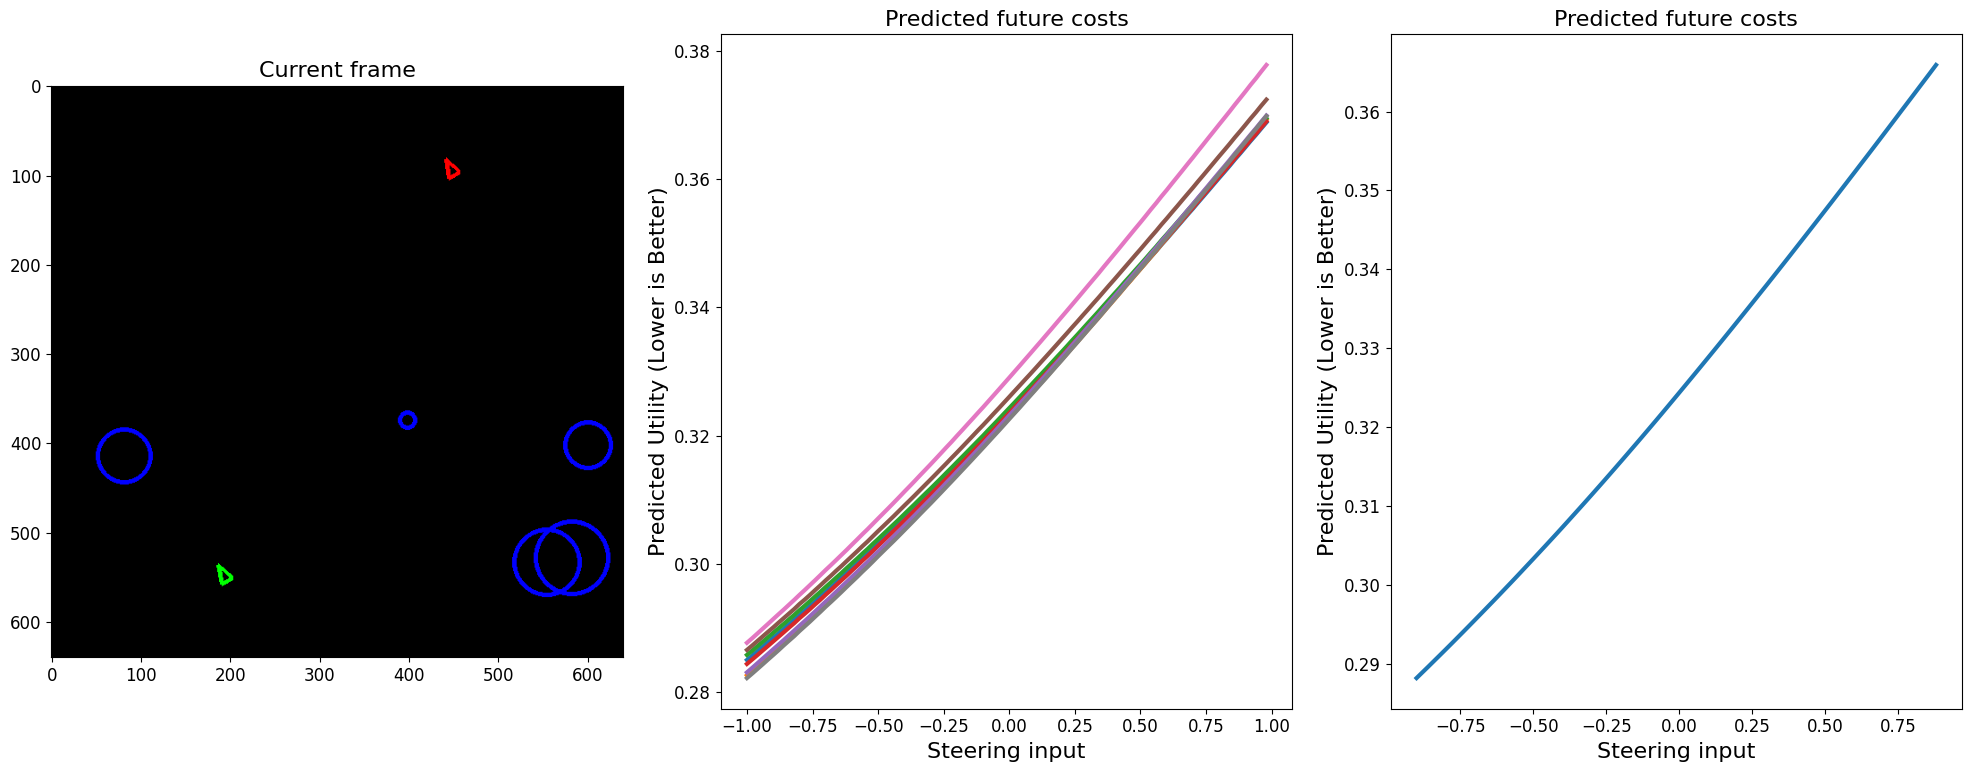

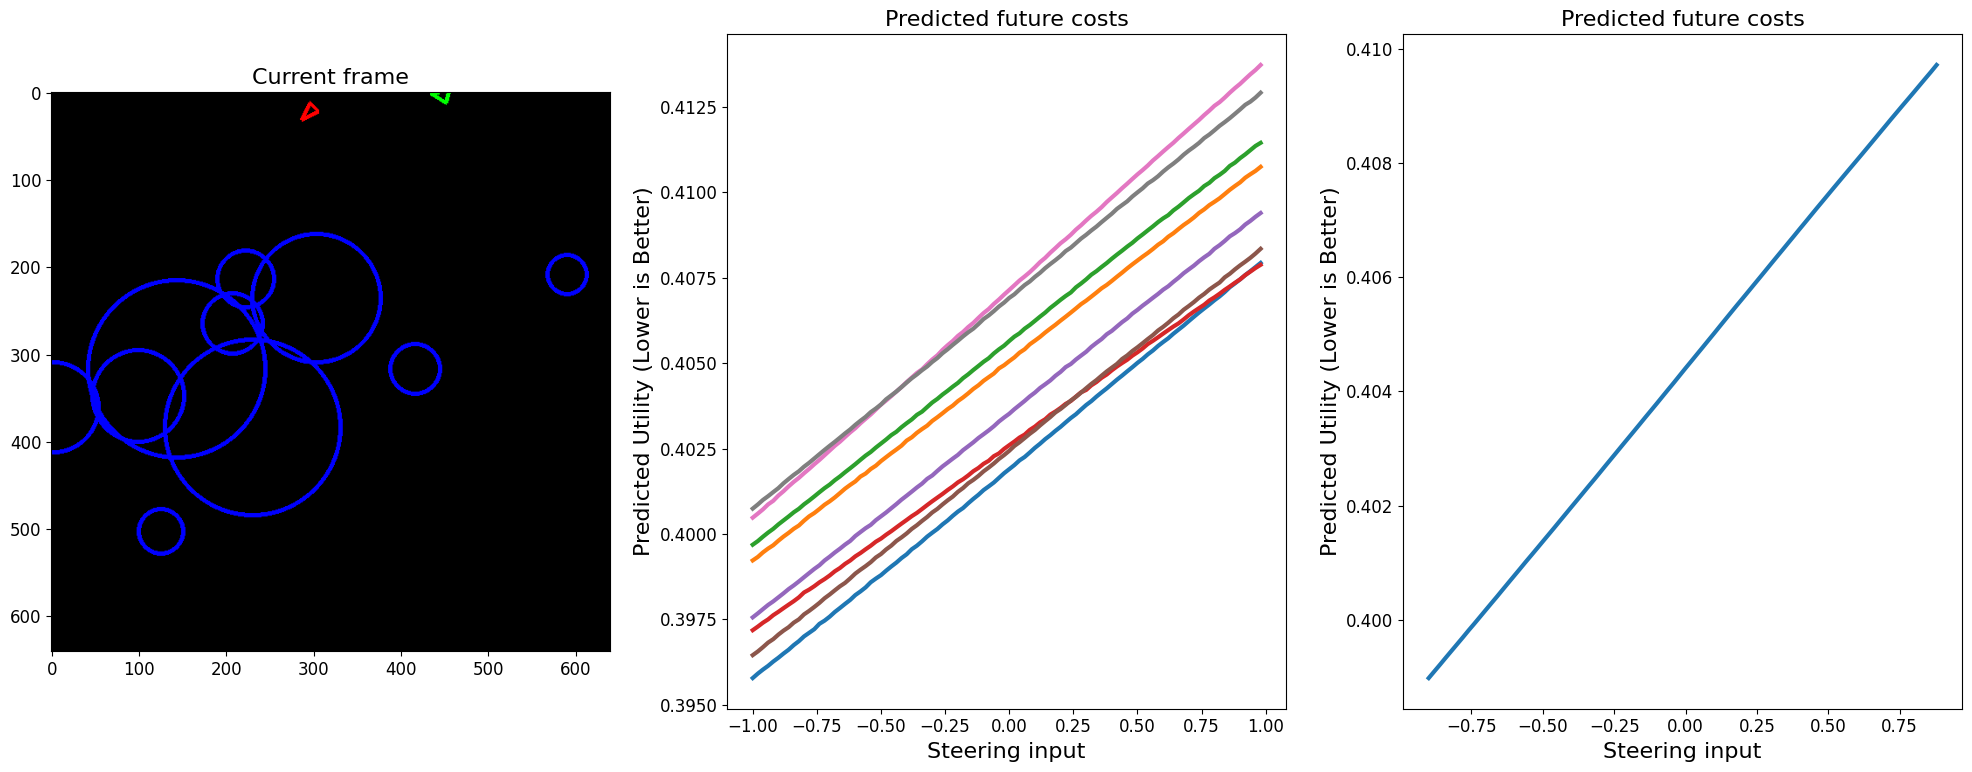

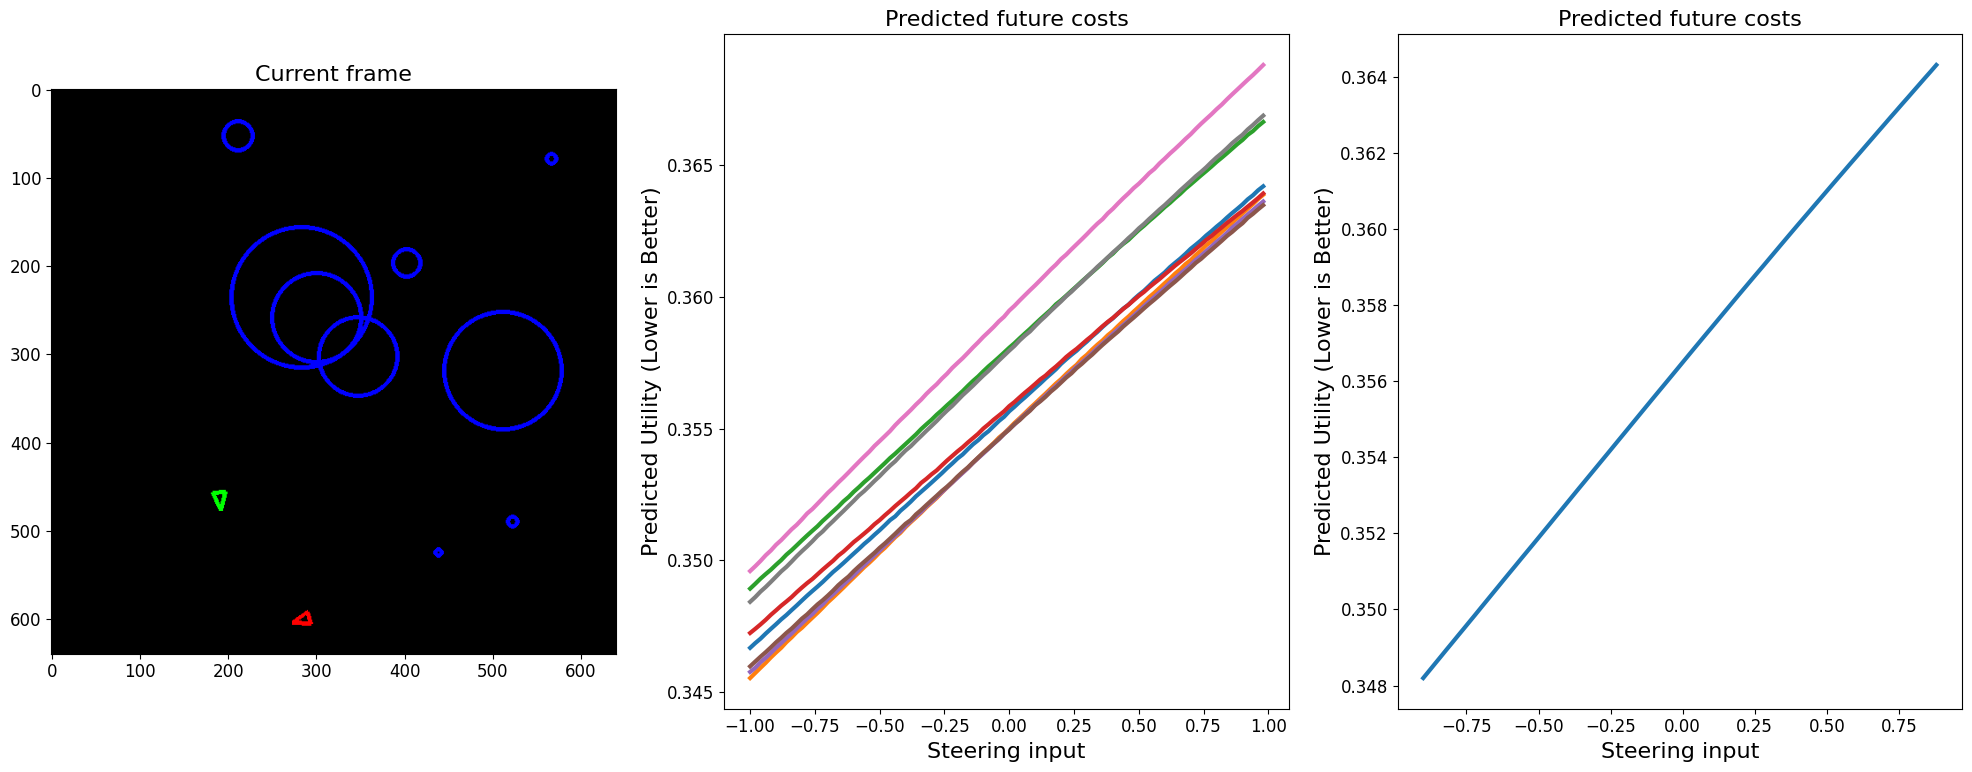

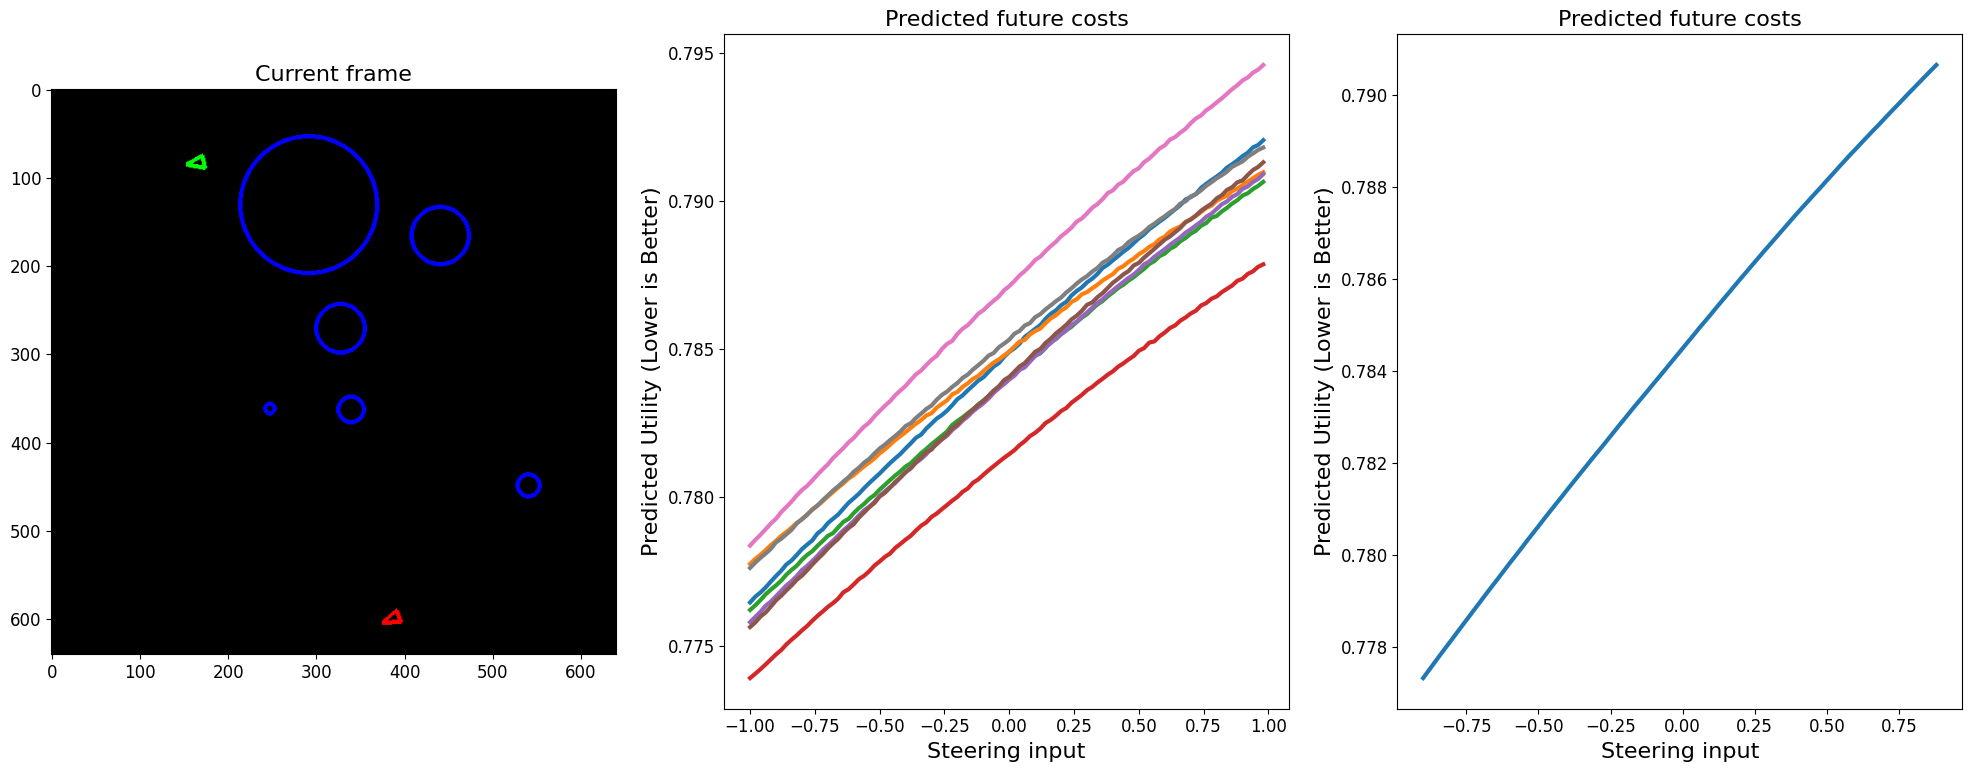

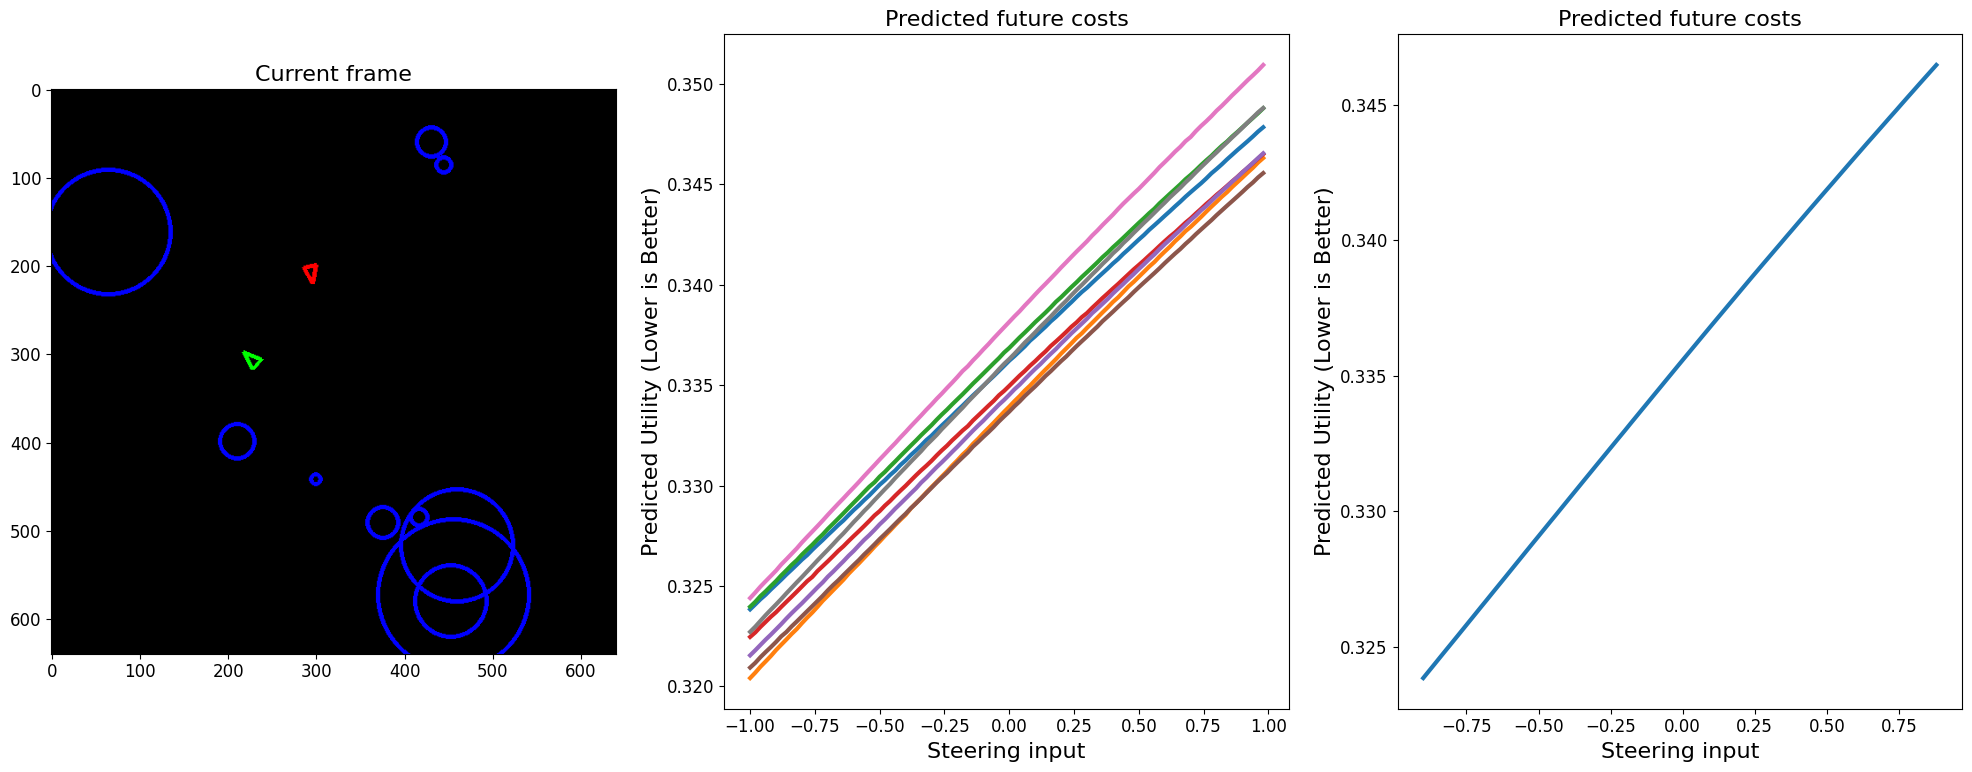

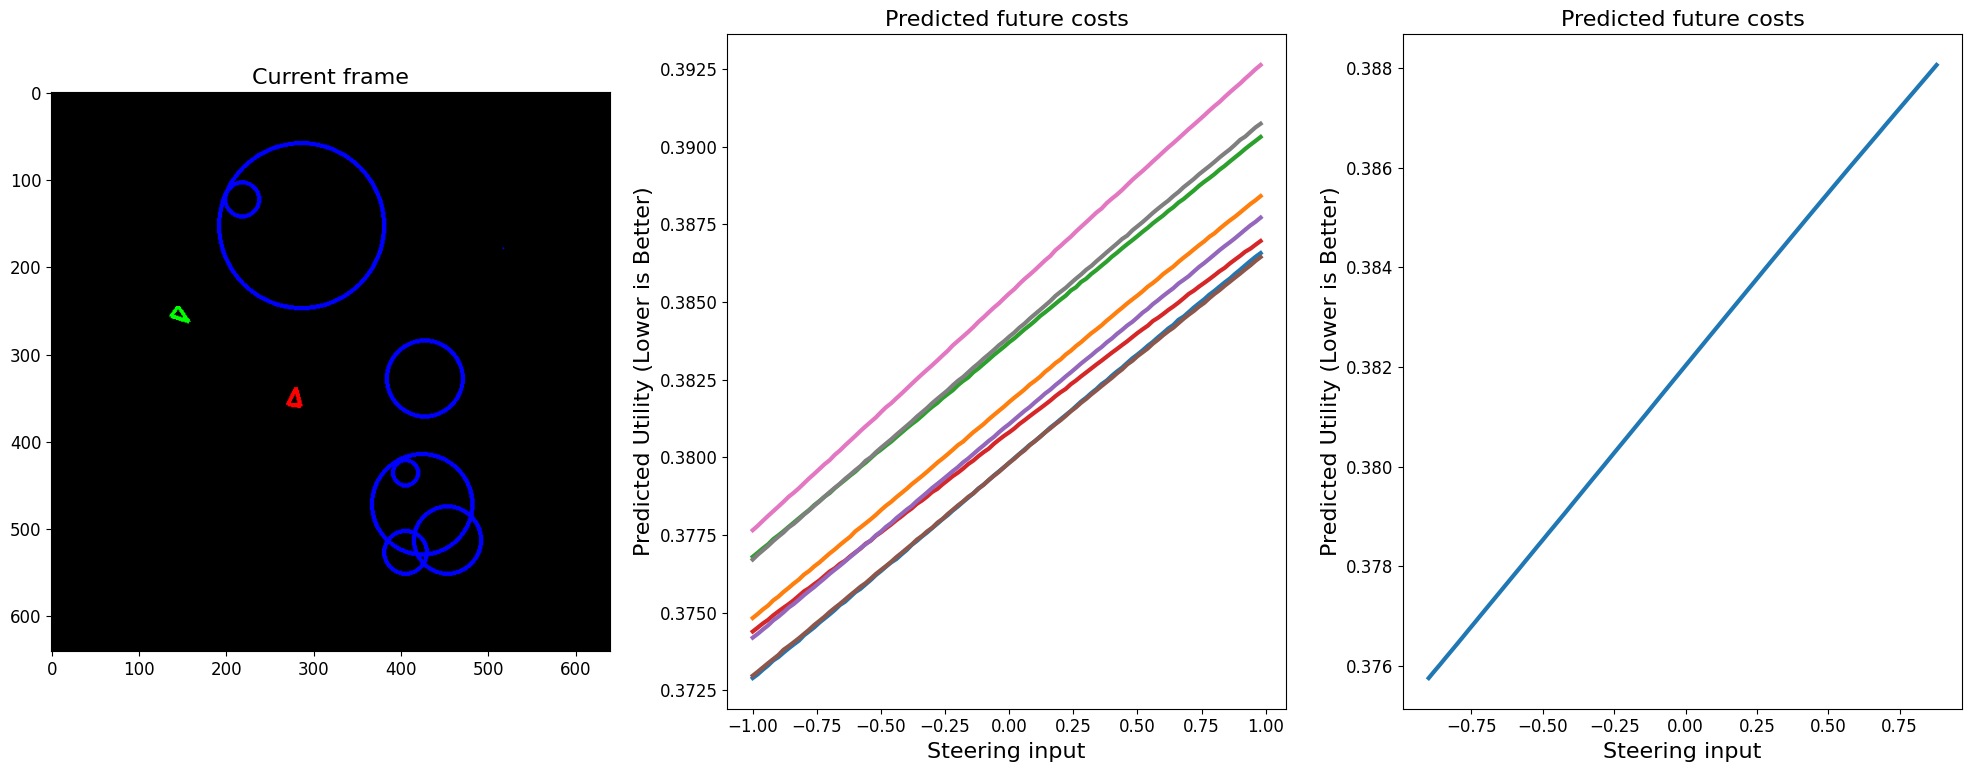

Tensor("model_11/keras_gen_action_layer_1/Shape:0", shape=(2,), dtype=int32)
39/39 [==============================] - 18s 444ms/step


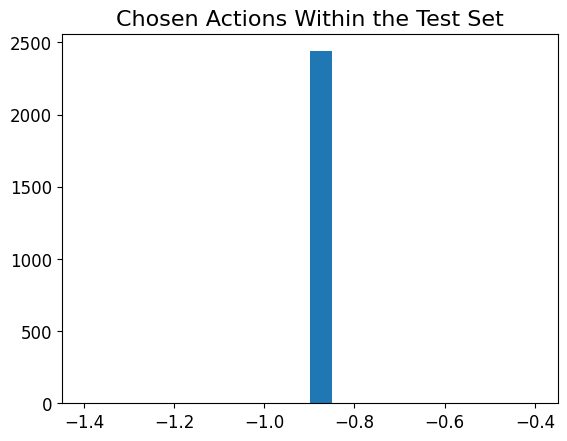

In [26]:
# Plot sanity test: how does turning effect score
import matplotlib.pyplot as plt

test_cc_ds = big_valid_ds.batch(16).take(1)

for elements in test_cc_ds.map(lambda w, x, y, z: (encoder(w), w, y, z)):
    move, costs, smoothed_costs = define_action(elements[0])
    for i in range(tf.shape(move)[0]):
        fig, ax = plt.subplots(1, 3, figsize=(20,8))

        # Plot image
        ax[0].imshow(tf.sparse.to_dense(elements[1])[i].numpy().astype(float))
        ax[0].set_title("Current frame")

        # Plot scores for each action
        ax[1].plot(tf.range(NUM_POSSIBLE_ACTIONS)/(NUM_POSSIBLE_ACTIONS//2) - 1, costs[i], linewidth=3)
        ax[1].set_title("Predicted future costs")
        ax[1].set_xlabel("Steering input")
        ax[1].set_ylabel("Predicted Utility (Lower is Better)")

        # Plot smoothed scores for each action
        num_actions = NUM_POSSIBLE_ACTIONS - 2 * ACTION_SPACE_SMOOTHING
        ax[2].plot((tf.range(num_actions) - (num_actions//2))/(NUM_POSSIBLE_ACTIONS//2), smoothed_costs[i], linewidth=3)
        ax[2].set_title("Predicted future costs")
        ax[2].set_xlabel("Steering input")
        ax[2].set_ylabel("Predicted Utility (Lower is Better)")

        plt.tight_layout()
        plt.show()
    # print(, tf.shape(costs), tf.shape(smoothed_costs))

all_actions = action_gen.predict(big_valid_ds.batch(64).map(lambda w, x, y, z: w))
plt.hist(all_actions[:, 0], bins=20)
plt.title("Chosen Actions Within the Test Set")
plt.show()